## Introduction
####  Machine Learning model to predict Accident Risk Index by using area/district level accident data.

### Import the necessary packages.

In [2]:
!pip install -q klib

     |████████████████████████████████| 132 kB 34.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import klib

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [5]:
train=pd.read_csv("/content/gdrive/MyDrive/MH_predict_accident_risk_score_for_unique_postcode/train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/MH_predict_accident_risk_score_for_unique_postcode/test.csv")

In [6]:
train=train.rename(columns={col:col.replace("-","_").lower() for col in train.columns.values})
test=test.rename(columns={col:col.replace("-","_").lower() for col in test.columns.values})

### Structure of the train and test dataset.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478741 entries, 0 to 478740
Data columns (total 27 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   accident_id                                  478741 non-null  int64 
 1   police_force                                 478741 non-null  int64 
 2   number_of_vehicles                           478741 non-null  int64 
 3   number_of_casualties                         478741 non-null  int64 
 4   date                                         478741 non-null  object
 5   day_of_week                                  478741 non-null  int64 
 6   time                                         478727 non-null  object
 7   local_authority_(district)                   478741 non-null  int64 
 8   local_authority_(highway)                    478741 non-null  object
 9   1st_road_class                               478741 non-null  int64 
 

#### The above information shows that there are 478741 data entries and 27 columns.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121259 entries, 0 to 121258
Data columns (total 27 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   accident_id                                  121259 non-null  int64 
 1   police_force                                 121259 non-null  int64 
 2   number_of_vehicles                           121259 non-null  int64 
 3   number_of_casualties                         121259 non-null  int64 
 4   date                                         121259 non-null  object
 5   day_of_week                                  121259 non-null  int64 
 6   time                                         121258 non-null  object
 7   local_authority_(district)                   121259 non-null  int64 
 8   local_authority_(highway)                    121259 non-null  object
 9   1st_road_class                               121259 non-null  int64 
 

#### The above information shows that there are 121259 data entries and 27 columns.

#### Let's see is there any missing values in train and test dataset by column wise.

In [ ]:
train.isnull().sum()

accident_id                                      0
police_force                                     0
number_of_vehicles                               0
number_of_casualties                             0
date                                             0
day_of_week                                      0
time                                            14
local_authority_(district)                       0
local_authority_(highway)                        0
1st_road_class                                   0
1st_road_number                                  0
road_type                                        0
speed_limit                                      0
2nd_road_class                                   0
2nd_road_number                                  0
pedestrian_crossing_human_control                0
pedestrian_crossing_physical_facilities          0
light_conditions                                 0
weather_conditions                               0
road_surface_conditions        

In [ ]:
train.columns[train.isnull().any()]

Index(['time', 'road_surface_conditions', 'special_conditions_at_site'], dtype='object')

#### The above information shows that there are missing values in the columns time, road_surface_conditions, special_conditions_at_site.

In [ ]:
test.isnull().sum()

accident_id                                     0
police_force                                    0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            1
local_authority_(district)                      0
local_authority_(highway)                       0
1st_road_class                                  0
1st_road_number                                 0
road_type                                       0
speed_limit                                     0
2nd_road_class                                  0
2nd_road_number                                 0
pedestrian_crossing_human_control               0
pedestrian_crossing_physical_facilities         0
light_conditions                                0
weather_conditions                              0
road_surface_conditions                        39


In [ ]:
test.columns[test.isnull().any()]

Index(['time', 'road_surface_conditions', 'special_conditions_at_site'], dtype='object')

#### The above information shows that there are missing values in the columns time, road_surface_conditions, special_conditions_at_site.

#### Let's see the glimpse of train dataset

In [ ]:
train.head(2)

accident_id  police_force  number_of_vehicles  number_of_casualties  \
0            1            34                   2                     1   
1            2             5                   2                     1   

       date  day_of_week   time  local_authority_(district)  \
0  19/12/12            7  13:20                         344   
1  02/11/12            4   7:53                         102   

  local_authority_(highway)  1st_road_class  ...  \
0                 E10000032               4  ...   
1                 E09000026               3  ...   

                 light_conditions          weather_conditions  \
0  Daylight: Street light present     Fine without high winds   
1  Daylight: Street light present  Raining without high winds   

   road_surface_conditions  special_conditions_at_site  carriageway_hazards  \
0                      Dry                Ol or diesel                 None   
1                      Dry                        None                 None   

  urban_or_rural_area did_police_officer_attend_scene_of_accident    state  \
0                   1                                         Yes  England   
1                   1                                          No  England   

  postcode         country  
0  OX3 9UP  United Kingdom  
1  S35 4EZ  United Kingdom  

[2 rows x 27 columns]

### Let's see is there any duplication

In [ ]:
train.duplicated().value_counts()

False    478741
dtype: int64

#### The above information shows that there is no duplication in data.

### Let's explore and visualize each column of the train dataset.First,let's see the target column distribution.

### At postcode wise total casualties from the road accidents divided by the count of accidents, we can get the target column **accident_risk_index**. 

### Function to get the accident_risk_index 

In [ ]:
def ari(df):
  df['total_casualties']=df.groupby('postcode')['number_of_casualties'].transform('sum')
  df['accident_count']=df.groupby('postcode')['accident_id'].transform('count')
  df['accident_risk_index']=round(df['total_casualties']/df['accident_count'],2)
  return df

In [ ]:
train=ari(train)

In [ ]:
train.head(2)

accident_id  police_force  number_of_vehicles  number_of_casualties  \
0            1            34                   2                     1   
1            2             5                   2                     1   

       date  day_of_week   time  local_authority_(district)  \
0  19/12/12            7  13:20                         344   
1  02/11/12            4   7:53                         102   

  local_authority_(highway)  1st_road_class  ...  special_conditions_at_site  \
0                 E10000032               4  ...                Ol or diesel   
1                 E09000026               3  ...                        None   

  carriageway_hazards  urban_or_rural_area  \
0                None                    1   
1                None                    1   

   did_police_officer_attend_scene_of_accident    state postcode  \
0                                          Yes  England  OX3 9UP   
1                                           No  England  S35 4EZ   

          country total_casualties accident_count accident_risk_index  
0  United Kingdom               11              6                1.83  
1  United Kingdom                4              3                1.33  

[2 rows x 30 columns]

In [7]:
def count_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.countplot(x=df[col],order=df[col].value_counts().index)
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.xlabel(col,fontsize=20)
  _=plt.xticks(fontsize=14,rotation=rot)

In [9]:
def box_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.boxplot(y=df[col])
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.ylabel(col,fontsize=20,rotation=rot)
  _=plt.yticks(fontsize=14)



In [10]:
def side_by_side_plot(df,grp,valcol,rot=None):
  clr="tab10"
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
  fig.tight_layout()
  sns.kdeplot(x=df[valcol], hue=df[grp],ax=ax1,p alette=clr)
  ax1.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
  ax1.set_xlabel(valcol,fontsize=20)
  sns.boxplot(x=df[grp],y=df[valcol],ax=ax2)
  ax2.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
  ax2.set_xlabel(grp,fontsize=20)
  ax2.tick_params(rotation=rot)

In [11]:
def group_summary(df,groupcol,value):
    return df.groupby(groupcol)[value].describe().reset_index().sort_values('mean',ascending=False)

### Let's see the accident_risk_index column distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


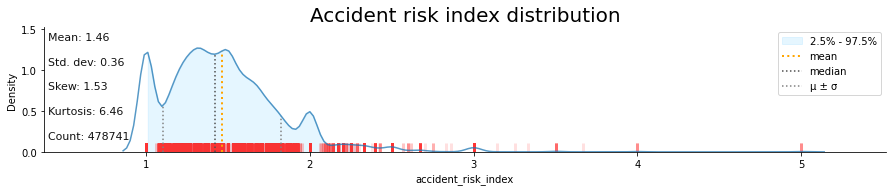

In [ ]:
klib.dist_plot(train['accident_risk_index']);
plt.title("accident risk index distribution".capitalize(),fontsize=20);

In [ ]:
train['accident_risk_index'].describe()

count    478741.000000
mean          1.463439
std           0.361019
min           1.000000
25%           1.220000
50%           1.420000
75%           1.670000
max           5.000000
Name: accident_risk_index, dtype: float64

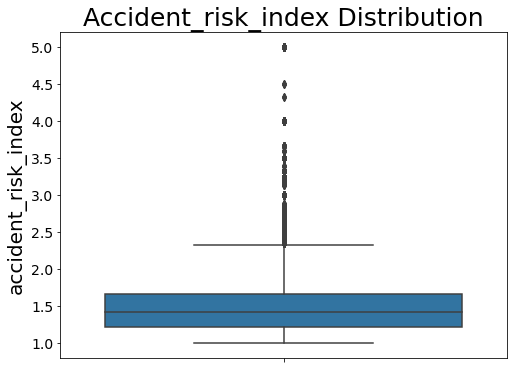

In [ ]:
box_plot(train,'accident_risk_index')

#### The above histogram explains that accident_risk_index column is postively skewed and also there are three peeks(multi-modal distribution).

### The accident_risk_index ranges from 1.0 to 5.0.

### The average accident_risk_index value is 1.47.

#### The boxplot explains that there are outliers above the third quartile.

### Let's see how many states' accident information is collected and see accident casualties of each state?

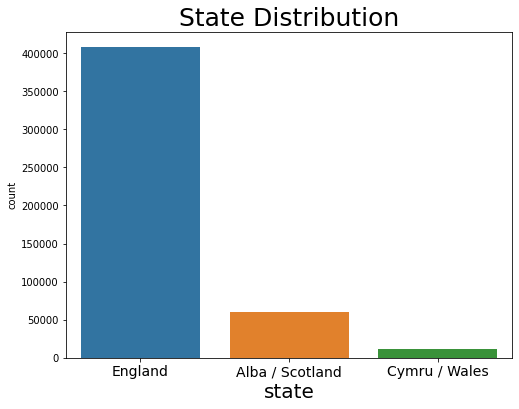

In [ ]:
count_plot(train,col='state')

In [ ]:
train['state'].value_counts()

England            407853
Alba / Scotland     59667
Cymru / Wales       11221
Name: state, dtype: int64

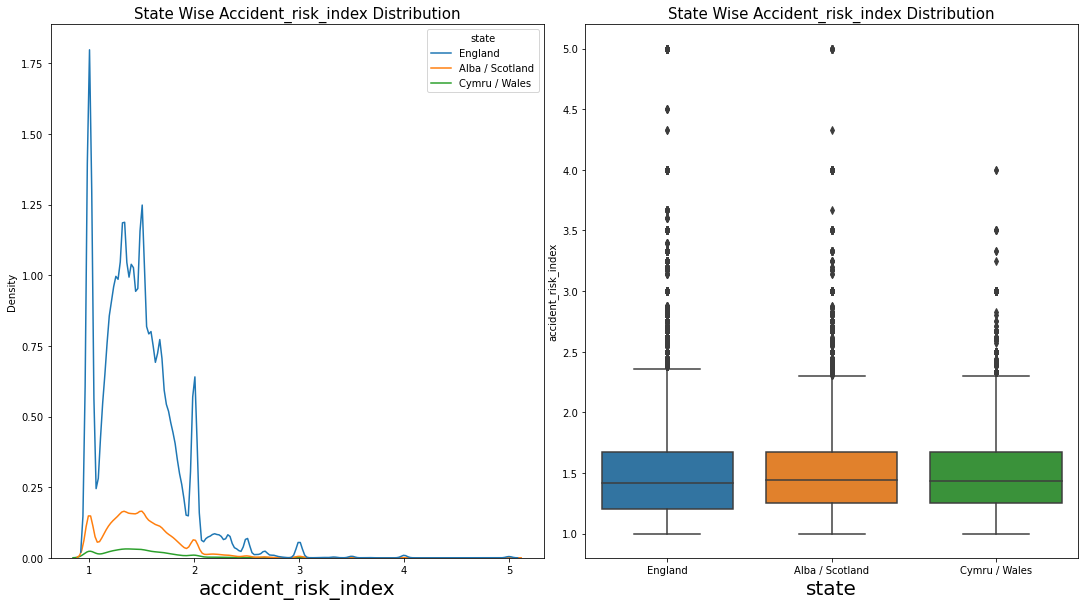

In [ ]:
side_by_side_plot(train,'state','accident_risk_index')

In [ ]:
group_summary(train,'state','accident_risk_index')

state     count      mean       std  min   25%   50%   75%  max
0  Alba / Scotland   59667.0  1.477671  0.348460  1.0  1.25  1.44  1.67  5.0
1    Cymru / Wales   11221.0  1.464700  0.336304  1.0  1.25  1.43  1.67  4.0
2          England  407853.0  1.461322  0.363427  1.0  1.20  1.42  1.67  5.0

#### The above group-wise box plot explains that mean of the accident_risk_index is almost the same in each state.

#### There are outliers above the third quartile and below the first quartile.

### Let's see how many unique postcodes are there and see which postcode area has the maximum road accident casualties.

In [ ]:
train['postcode'].nunique()

95625

#### There are 95625 unique pincodes are there.

### The postcode divided into four parts for instance **OX3 9AP**, the **OX** is area, **3** is district, **9** is sector, and **UP** is unit(street, property, organization).

### In this data the postcode length is in various size.For instance,

* DL145 8BG ->(length:9)
* BN21 2XR ->(length:8)
* OX3 9UP ->(length:7)
* E5 9QH ->(length:6)
* CB1 4 ->(length:5)
* PE21 ->(length:4)
* GU9 ->(length:3)
* S8 ->(length:2)

### Let's use the regex function to retrieve the four parts in postcode.

In [ ]:
def postcode_split(df):
  df['postcode']=df['postcode'].str.strip()
  df['area']=[re.search(r"([A-Z]+)",i).group(1) for i in df['postcode']]
  df['district']=[re.search(r"[A-Z]+([0-9]+)",i).group(1) if re.search(r"[A-Z]+([0-9]+)",i) else "none" for i in df['postcode']]
  df['sector']=[re.search(r"(\s[0-9]+)",i).group(1) if re.search(r"(\s[0-9]+?)",i) else "none" for i in df['postcode']]
  df['unit']=[re.search(r"\s[0-9]+([A-Z]+)",i).group(1) if re.search(r"\s[0-9]+?([A-Z]+)",i) else "none" for i in df['postcode']]
  return df

In [ ]:
train=postcode_split(train)

#### Let's see in which area, district, sector, and unit have most accidents occurred.

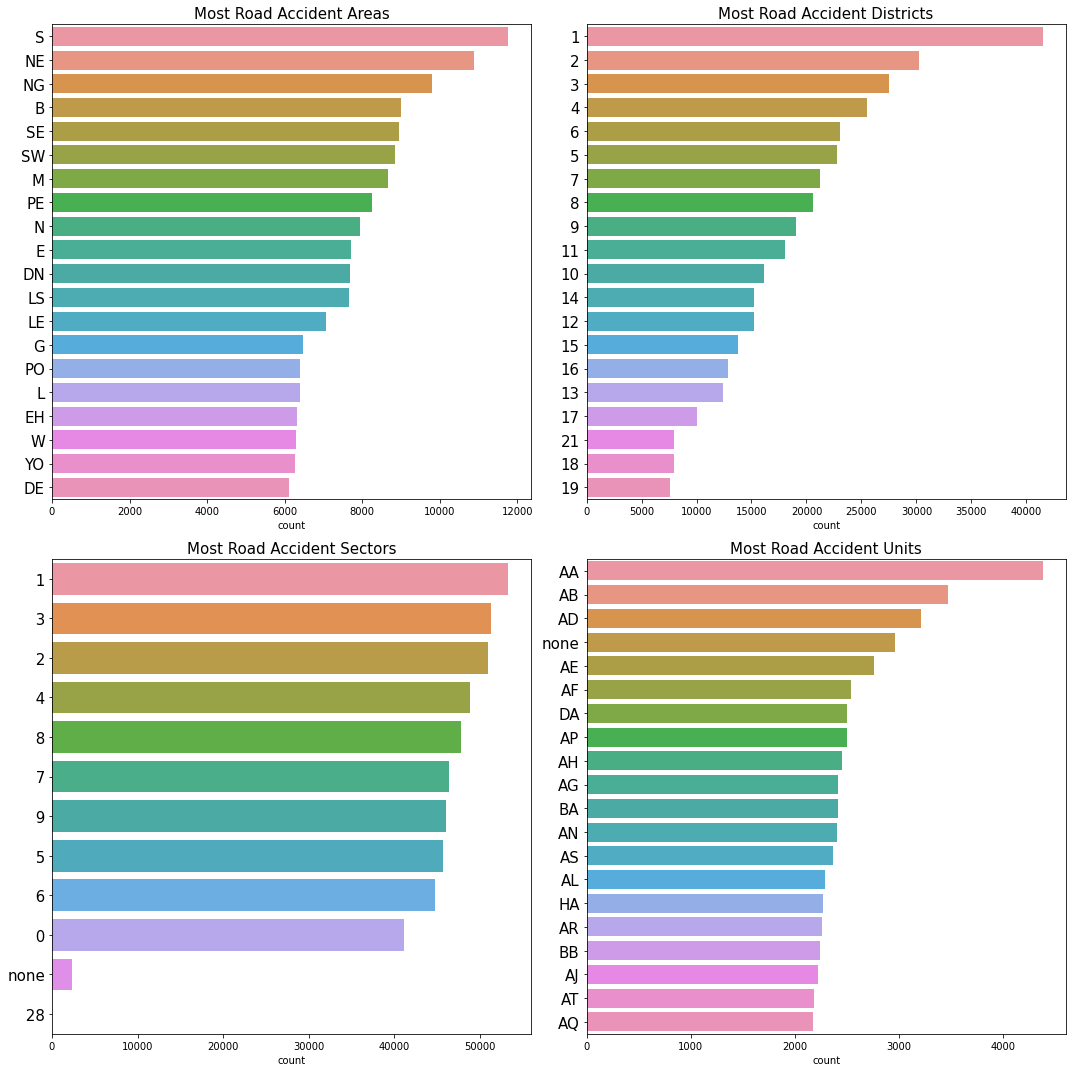

In [ ]:
fig=plt.subplots(figsize=(15,15))
for i,col in enumerate(['area','district','sector','unit']):
  _=plt.subplot(2,2,i+1)
  df=train.groupby(col)['accident_id'].agg({'count'}).reset_index().nlargest(20,'count')
  _=sns.barplot(data=df,x='count',y=col)
  _=plt.title("Most Road Accident "+col.capitalize()+'s',fontsize=15)
  _=plt.ylabel("")
  _=plt.yticks(fontsize=15)
  _=plt.tight_layout()
plt.show()    

#### Let's see in which area, district, sector, and the unit have the most road accident casualties.

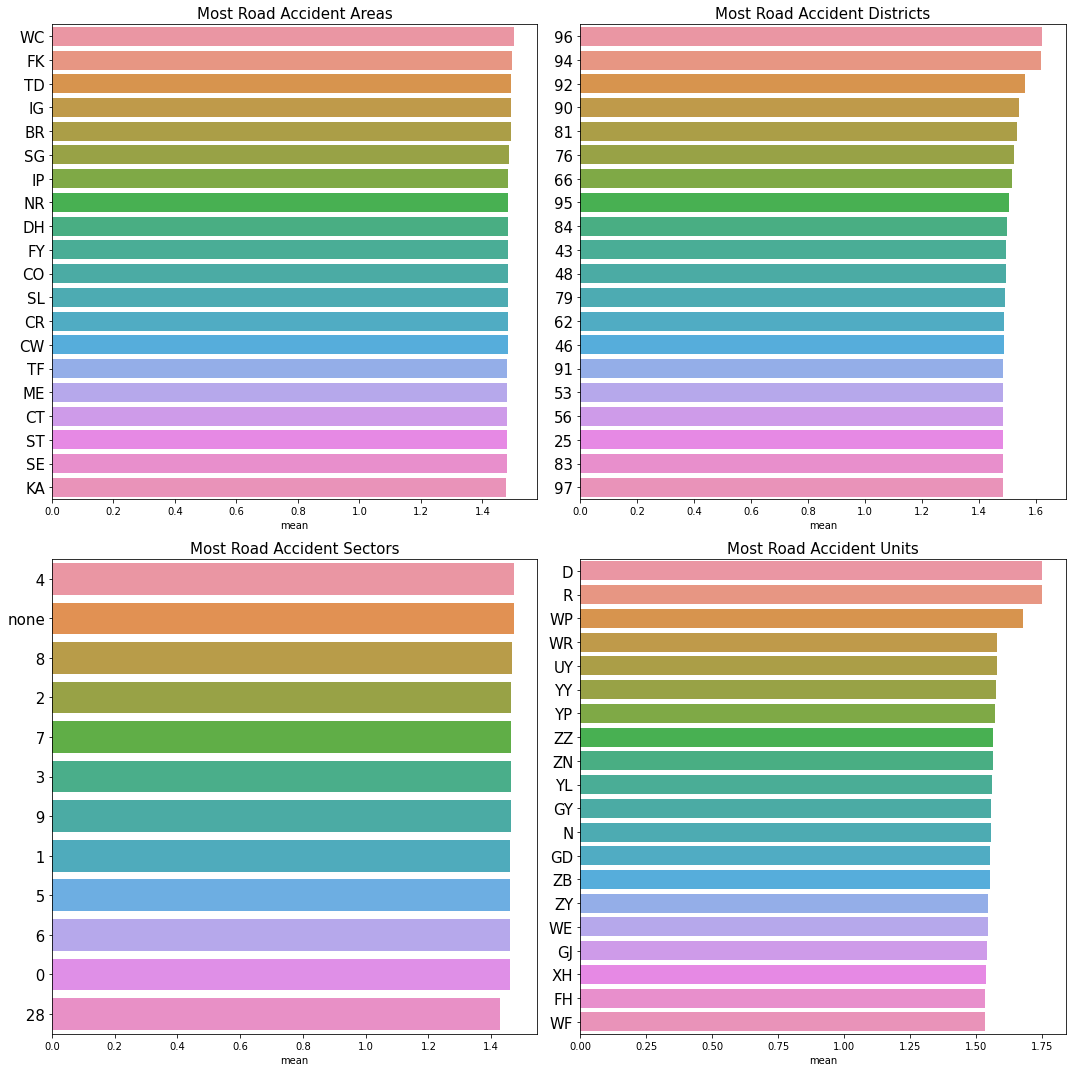

In [ ]:
fig=plt.subplots(figsize=(15,15))
for i,col in enumerate(['area','district','sector','unit']):
  _=plt.subplot(2,2,i+1)
  df=train.groupby(col)['number_of_casualties'].agg({'mean'}).reset_index().nlargest(20,'mean')
  _=sns.barplot(data=df,x='mean',y=col)
  _=plt.title("Most Road Accident "+col.capitalize()+'s',fontsize=15)
  _=plt.ylabel("")
  _=plt.yticks(fontsize=15)
  _=plt.tight_layout()
plt.show()    

#### Let's see in which area, district, sector, and unit have the high accidents risk index.

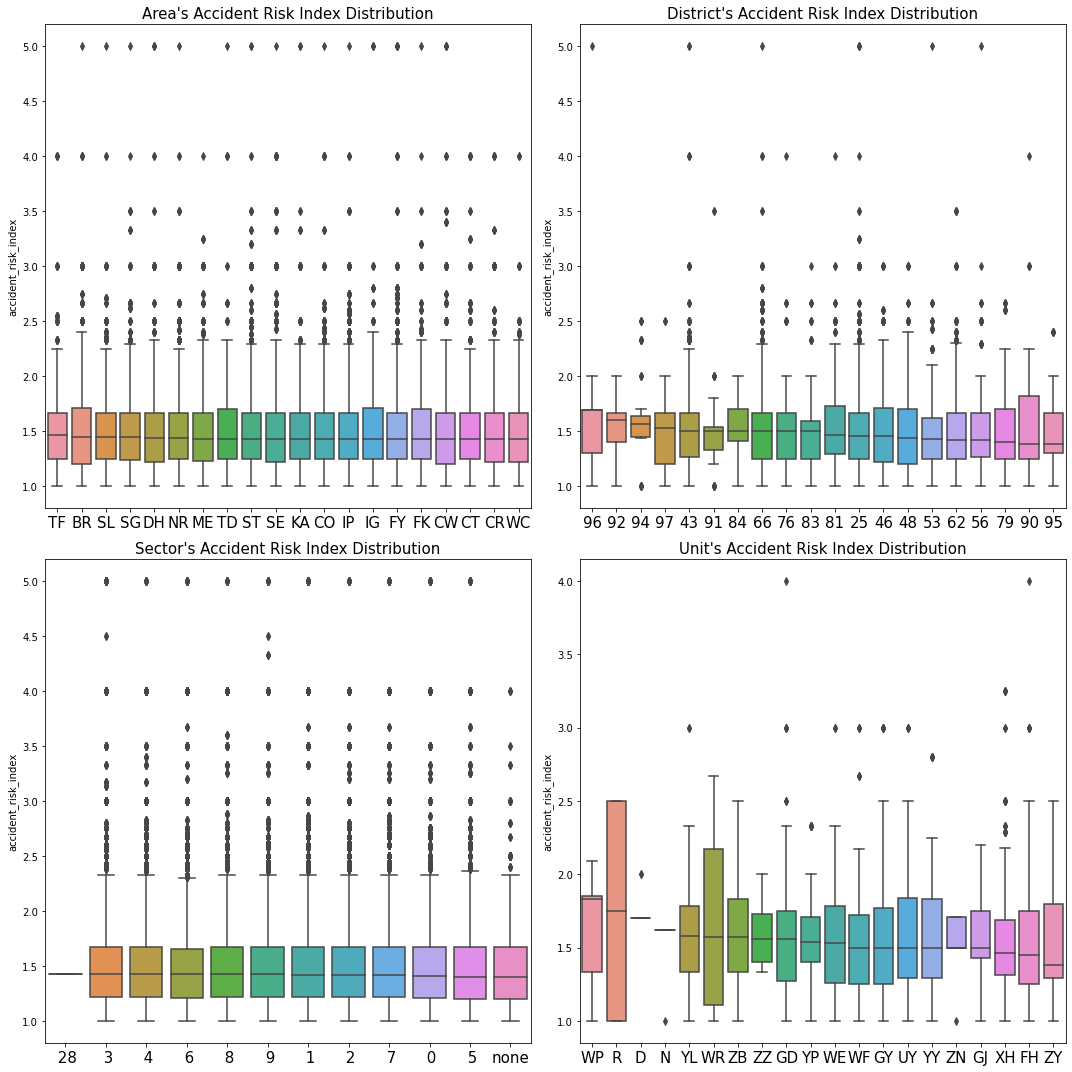

In [ ]:
fig=plt.subplots(figsize=(15,15))
for i,col in enumerate(['area','district','sector','unit']):
  _=plt.subplot(2,2,i+1)
  df=train.groupby(col)['accident_risk_index'].agg({'mean'}).reset_index().nlargest(20,'mean')
  df1=train[train[col].isin(list(df[col].values))][[col,'accident_risk_index']]
  order = df1.groupby(col)["accident_risk_index"].median().sort_values(ascending=False).index
  _=sns.boxplot(x=df1[col],y=df1['accident_risk_index'],order=order)
  _=plt.title(col.capitalize()+"'s"+" Accident Risk Index Distribution",fontsize=15)
  _=plt.xlabel("")
  _=plt.xticks(fontsize=15)
  _=plt.tight_layout()
plt.show()  

#### The above boxplots are ordered by the median value and it explains that there is a lot of differences between most road accident locations and the locations which have the most accident casualties and also most accident risk index locations.

### Let' compare the number of police force and accident risk index, accident count, and total casualties.

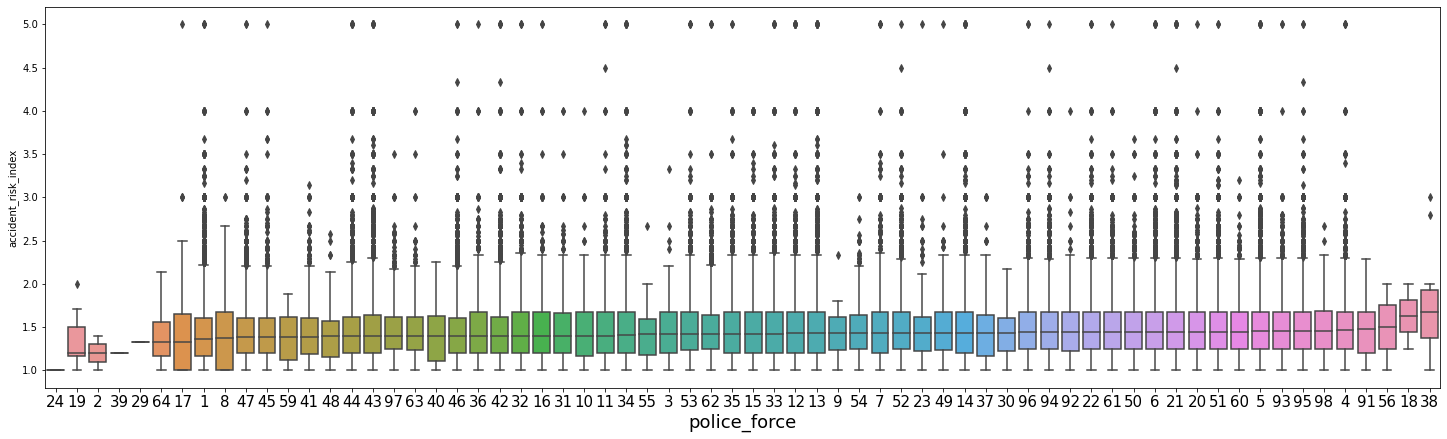

In [ ]:
plt.figure(figsize=(25,7))
sns.boxplot(x=train['police_force'].astype('str'),y=train['accident_risk_index'],
            order=(train.astype({'police_force':'str'}).groupby('police_force')['accident_risk_index'].median().
                   sort_values(ascending=True).index));
plt.xlabel("police_force",fontsize=18);
plt.xticks(fontsize=15); 

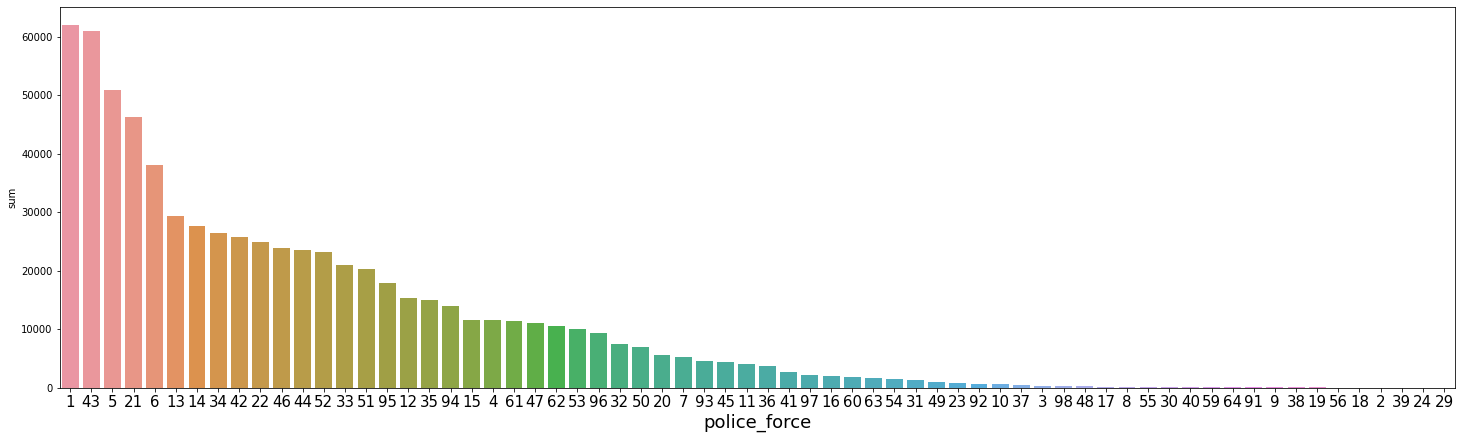

In [ ]:
plt.figure(figsize=(25,7))
sns.barplot(data=train.astype({'police_force':'str'}).groupby('police_force')['number_of_casualties'].agg({'sum'}).reset_index(),
    x='police_force',y='sum',
            order=(train.astype({'police_force':'str'}).groupby('police_force')['number_of_casualties'].sum().
                   sort_values(ascending=False).index));
plt.xlabel("police_force",fontsize=18);
plt.xticks(fontsize=15) ;

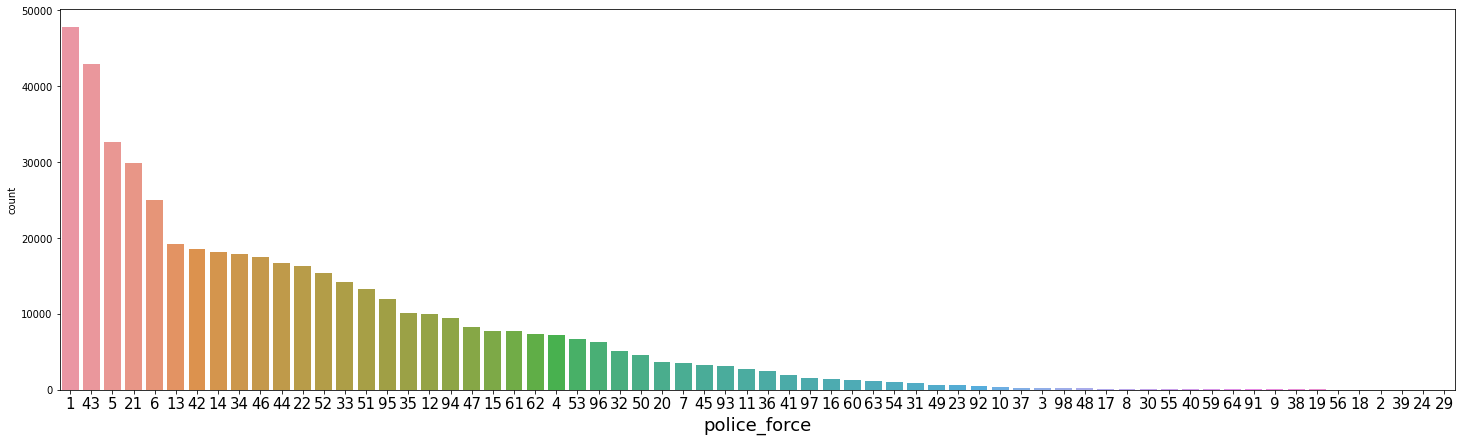

In [ ]:
plt.figure(figsize=(25,7))
sns.barplot(data=train.astype({'police_force':'str'}).groupby('police_force')['accident_id'].agg({'count'}).reset_index(),
    x='police_force',y='count',
            order=(train.astype({'police_force':'str'}).groupby('police_force')['total_casualties'].count().
                   sort_values(ascending=False).index));
plt.xlabel("police_force",fontsize=18);
plt.xticks(fontsize=15);                   

#### The above boxplot the accident risk index's median values is almost similar.

#### There are some less accident risk index in the some areas.

#### There average number of police force is 31.

#### The number of police force ranges from 1 to 98.

#### The area which has 24 police force is recorded the very lowest accident risk index(1.0).

#### There is a lot of differences between most road accident locations and the locations which have the most accident casualties and also most accident risk index locations.

### Let's see the number of vehicles on accident location and compare it with the accident risk index.

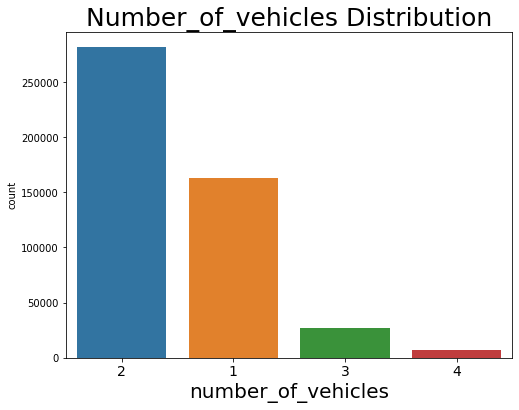

In [ ]:
count_plot(train,col='number_of_vehicles')

In [ ]:
train['number_of_vehicles'].value_counts()

2    281598
1    163061
3     26849
4      7233
Name: number_of_vehicles, dtype: int64

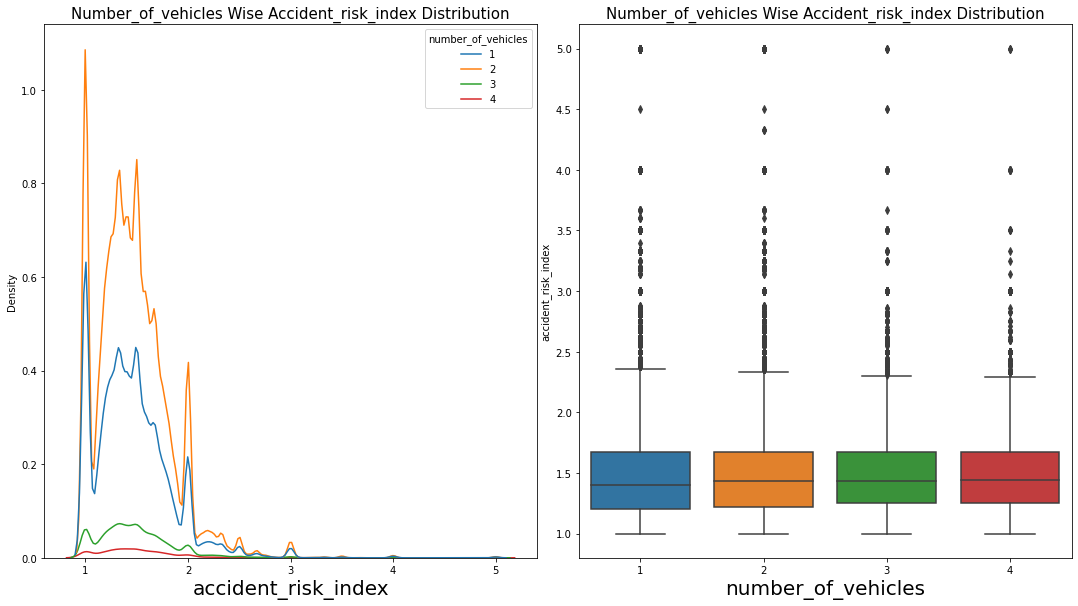

In [ ]:
side_by_side_plot(train,'number_of_vehicles','accident_risk_index')

In [ ]:
group_summary(train,'number_of_vehicles','accident_risk_index')

number_of_vehicles     count      mean       std  min   25%   50%   75%  \
3                   4    7233.0  1.483585  0.364969  1.0  1.25  1.44  1.67   
2                   3   26849.0  1.476658  0.356312  1.0  1.25  1.43  1.67   
1                   2  281598.0  1.465068  0.355599  1.0  1.22  1.43  1.67   
0                   1  163061.0  1.457555  0.370659  1.0  1.20  1.40  1.67   

   max  
3  5.0  
2  5.0  
1  5.0  
0  5.0

### Let's compare the state-wise accident risk index by each number of vehicles at the accident location.

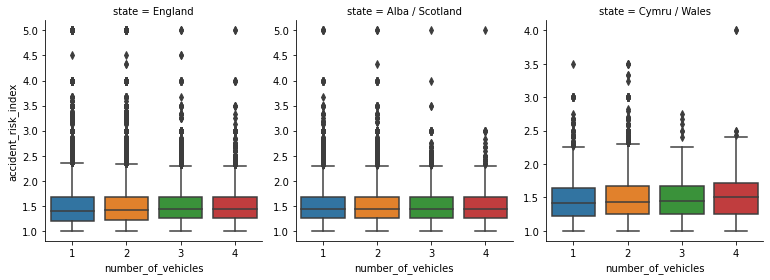

In [ ]:
sns.catplot(x='number_of_vehicles',y='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','number_of_vehicles'],'accident_risk_index')

state  number_of_vehicles     count      mean       std  min  \
7     Cymru / Wales                   4     218.0  1.518028  0.414056  1.0   
3   Alba / Scotland                   4    1300.0  1.484585  0.352338  1.0   
2   Alba / Scotland                   3    3894.0  1.484271  0.346021  1.0   
11          England                   4    5715.0  1.482044  0.365798  1.0   
1   Alba / Scotland                   2   30103.0  1.479450  0.345103  1.0   
10          England                   3   22272.0  1.475496  0.359351  1.0   
0   Alba / Scotland                   1   24370.0  1.474050  0.352725  1.0   
6     Cymru / Wales                   3     683.0  1.471171  0.311716  1.0   
5     Cymru / Wales                   2    6808.0  1.468440  0.334529  1.0   
9           England                   2  244687.0  1.463205  0.357395  1.0   
8           England                   1  135179.0  1.454702  0.374516  1.0   
4     Cymru / Wales                   1    3512.0  1.452882  0.338591  1.0   

     25%   50%   75%   max  
7   1.25  1.50  1.71  4.00  
3   1.25  1.44  1.67  5.00  
2   1.25  1.44  1.67  5.00  
11  1.25  1.44  1.67  5.00  
1   1.25  1.44  1.67  5.00  
10  1.25  1.43  1.67  5.00  
0   1.25  1.43  1.67  5.00  
6   1.25  1.44  1.67  2.75  
5   1.25  1.43  1.67  3.50  
9   1.22  1.42  1.67  5.00  
8   1.20  1.40  1.67  5.00  
4   1.22  1.42  1.64  3.50

#### The above plot explains that there are mostly 1 or 2 vehicles at the location of the accident.

#### The average accident risk index is almost the same in all vehicle groups. 



### Let's compare the state-wise total accident by each number of vehicles at the accident location.

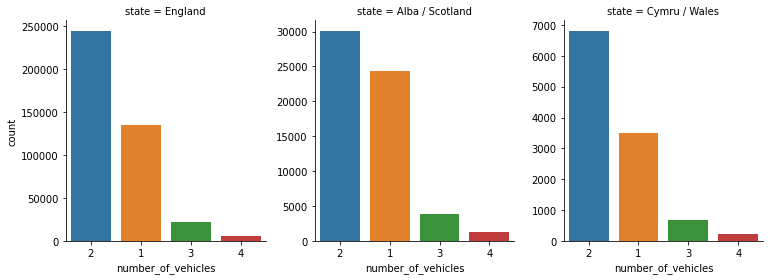

In [ ]:
sns.catplot(x='number_of_vehicles',y='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'number_of_vehicles':'str'}).groupby(['state','number_of_vehicles'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");

In [ ]:
(train.astype({'number_of_vehicles':'str'}).groupby(['state','number_of_vehicles'])
            .agg({'accident_id':'count'}).reset_index().sort_values('accident_id',ascending=False))

state number_of_vehicles  accident_id
9           England                  2       244687
8           England                  1       135179
1   Alba / Scotland                  2        30103
0   Alba / Scotland                  1        24370
10          England                  3        22272
5     Cymru / Wales                  2         6808
11          England                  4         5715
2   Alba / Scotland                  3         3894
4     Cymru / Wales                  1         3512
3   Alba / Scotland                  4         1300
6     Cymru / Wales                  3          683
7     Cymru / Wales                  4          218

#### In all states, most of the accidents happened due to two-vehicle crashes.

### Let's compare the state-wise total accident casualties by each number of vehicles at the accident location.

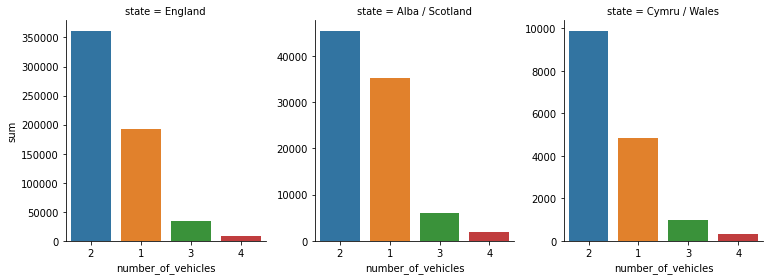

In [ ]:
sns.catplot(x='number_of_vehicles',y='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'number_of_vehicles':'str'}).groupby(['state','number_of_vehicles'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");

In [ ]:
(train.astype({'number_of_vehicles':'str'}).groupby(['state','number_of_vehicles'])
            .agg({'number_of_casualties':'sum'}).reset_index().sort_values('number_of_casualties',ascending=False))

state number_of_vehicles  number_of_casualties
9           England                  2                361354
8           England                  1                192663
1   Alba / Scotland                  2                 45382
0   Alba / Scotland                  1                 35184
10          England                  3                 33402
5     Cymru / Wales                  2                  9881
11          England                  4                  8678
2   Alba / Scotland                  3                  5952
4     Cymru / Wales                  1                  4855
3   Alba / Scotland                  4                  1981
6     Cymru / Wales                  3                   999
7     Cymru / Wales                  4                   320

#### In all states, most of the accident casualties happened due to two-vehicle crashes.

### Let's comapre the accident risk index with road type.

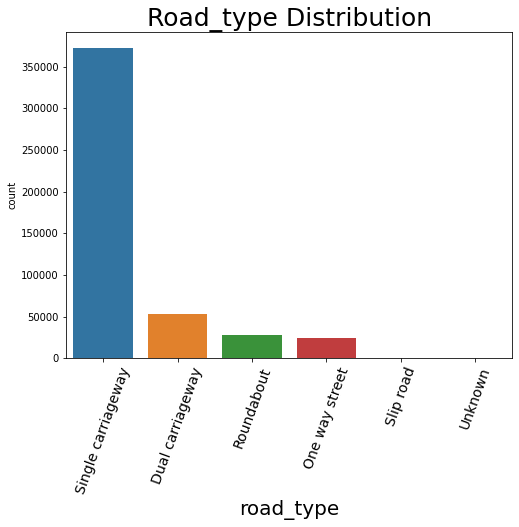

In [ ]:
count_plot(train,'road_type',rot=70)

In [ ]:
train['road_type'].value_counts()

Single carriageway    372554
Dual carriageway       52783
Roundabout             28541
One way street         24311
Slip road                523
Unknown                   29
Name: road_type, dtype: int64

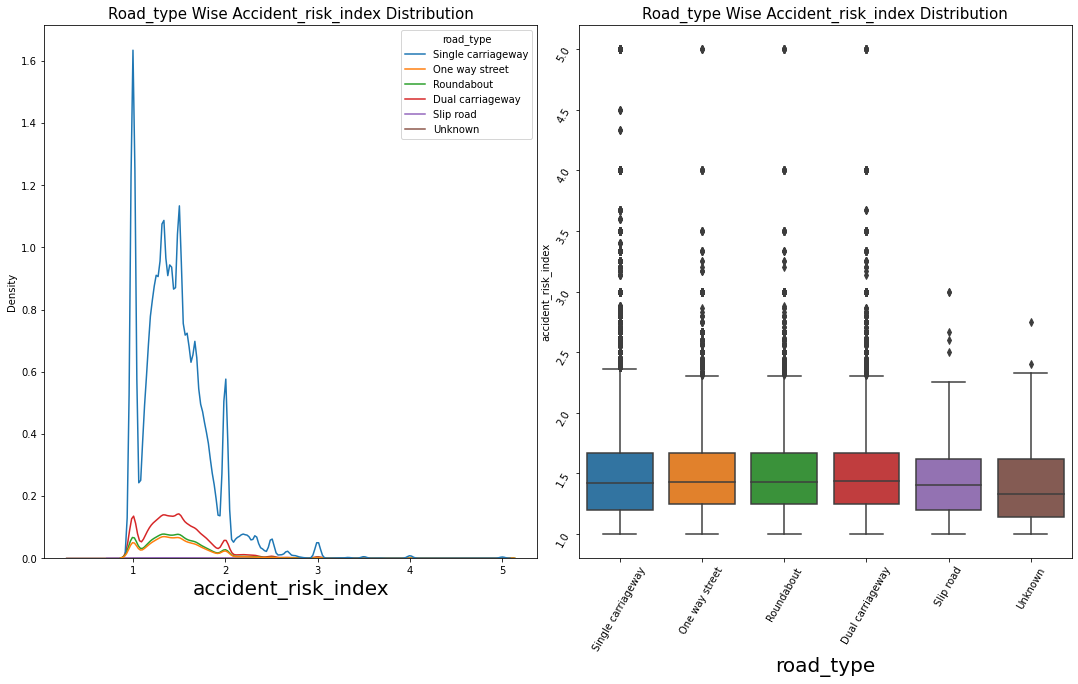

In [ ]:
side_by_side_plot(train,'road_type','accident_risk_index',rot=60)

In [ ]:
group_summary(train,'road_type','accident_risk_index')

road_type     count      mean       std  min   25%   50%   75%  \
0    Dual carriageway   52783.0  1.478542  0.355665  1.0  1.25  1.44  1.67   
1      One way street   24311.0  1.473911  0.337764  1.0  1.25  1.43  1.67   
2          Roundabout   28541.0  1.471070  0.350267  1.0  1.25  1.43  1.67   
3  Single carriageway  372554.0  1.460063  0.363995  1.0  1.20  1.42  1.67   
5             Unknown      29.0  1.446207  0.469950  1.0  1.14  1.33  1.62   
4           Slip road     523.0  1.441396  0.331476  1.0  1.20  1.40  1.62   

    max  
0  5.00  
1  5.00  
2  5.00  
3  5.00  
5  2.75  
4  3.00

#### The above plot explains that in all area most of roads are single carriageway.

#### The average accident risk index is almost the same in all road types. 



### Let's compare the state-wise accident risk index by type of the road.

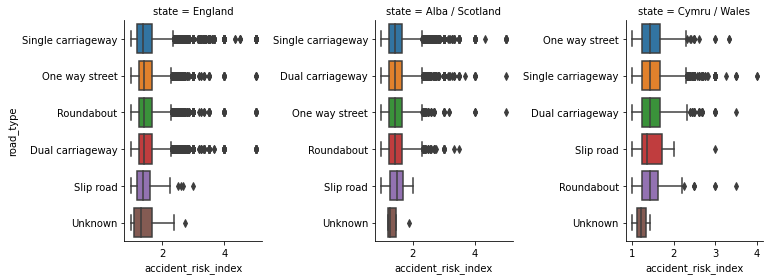

In [ ]:
sns.catplot(y='road_type',x='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','road_type'],'accident_risk_index')

state           road_type     count      mean       std  min  \
4   Alba / Scotland           Slip road      74.0  1.489730  0.272517  1.0   
0   Alba / Scotland    Dual carriageway   14539.0  1.481373  0.340724  1.0   
1   Alba / Scotland      One way street    2715.0  1.480645  0.335057  1.0   
2   Alba / Scotland          Roundabout    2254.0  1.479374  0.329787  1.0   
12          England    Dual carriageway   36015.0  1.478287  0.362969  1.0   
3   Alba / Scotland  Single carriageway   40081.0  1.476016  0.353247  1.0   
13          England      One way street   20643.0  1.473093  0.339032  1.0   
17          England             Unknown      23.0  1.473043  0.506166  1.0   
7     Cymru / Wales      One way street     953.0  1.472455  0.317428  1.0   
14          England          Roundabout   25882.0  1.470675  0.352322  1.0   
10    Cymru / Wales           Slip road      41.0  1.467073  0.380140  1.0   
9     Cymru / Wales  Single carriageway    7591.0  1.464710  0.340441  1.0   
6     Cymru / Wales    Dual carriageway    2229.0  1.464181  0.330761  1.0   
15          England  Single carriageway  324882.0  1.457987  0.365781  1.0   
8     Cymru / Wales          Roundabout     405.0  1.450099  0.328119  1.0   
16          England           Slip road     408.0  1.430049  0.335827  1.0   
5   Alba / Scotland             Unknown       4.0  1.405000  0.329090  1.2   
11    Cymru / Wales             Unknown       2.0  1.220000  0.311127  1.0   

       25%    50%    75%   max  
4   1.2925  1.500  1.690  2.00  
0   1.2500  1.440  1.670  5.00  
1   1.2500  1.440  1.670  5.00  
2   1.2500  1.440  1.670  3.50  
12  1.2500  1.430  1.670  5.00  
3   1.2500  1.430  1.670  5.00  
13  1.2500  1.430  1.670  5.00  
17  1.1050  1.330  1.685  2.75  
7   1.2500  1.440  1.670  3.33  
14  1.2500  1.430  1.670  5.00  
10  1.2300  1.360  1.710  3.00  
9   1.2500  1.430  1.670  4.00  
6   1.2300  1.430  1.670  3.50  
15  1.2000  1.400  1.670  5.00  
8   1.2300  1.430  1.620  3.50  
16  1.2000  1.400  1.620  3.00  
5   1.2000  1.265  1.470  1.89  
11  1.1100  1.220  1.330  1.44

#### The above plot explains that in all states the accident risk index is almost similar in all road types.

### Let's compare the state-wise total accident count by type of the road.

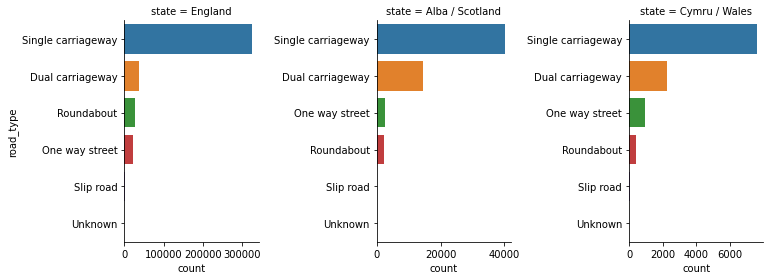

In [ ]:
sns.catplot(y='road_type',x='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'road_type':'str'}).groupby(['state','road_type'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'road_type':'str'}).groupby(['state','road_type'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state           road_type   count
15          England  Single carriageway  324882
3   Alba / Scotland  Single carriageway   40081
12          England    Dual carriageway   36015
14          England          Roundabout   25882
13          England      One way street   20643
0   Alba / Scotland    Dual carriageway   14539
9     Cymru / Wales  Single carriageway    7591
1   Alba / Scotland      One way street    2715
2   Alba / Scotland          Roundabout    2254
6     Cymru / Wales    Dual carriageway    2229
7     Cymru / Wales      One way street     953
16          England           Slip road     408
8     Cymru / Wales          Roundabout     405
4   Alba / Scotland           Slip road      74
10    Cymru / Wales           Slip road      41
17          England             Unknown      23
5   Alba / Scotland             Unknown       4
11    Cymru / Wales             Unknown       2

#### Most of the accidents happened in single carriageways and in the state of England.

### Let's compare the state-wise total accident casualties by type of the road.

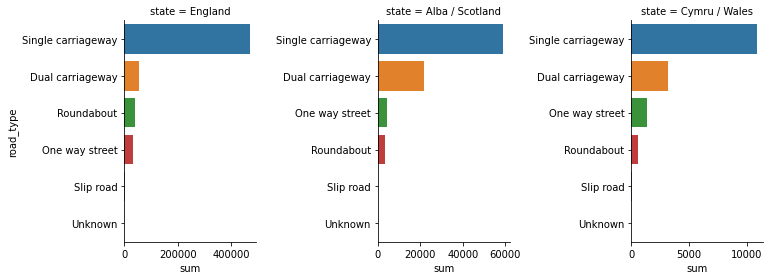

In [ ]:
sns.catplot(y='road_type',x='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'road_type':'str'}).groupby(['state','road_type'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'road_type':'str'}).groupby(['state','road_type'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state           road_type     sum
15          England  Single carriageway  471287
3   Alba / Scotland  Single carriageway   59159
12          England    Dual carriageway   54692
14          England          Roundabout   38865
13          England      One way street   30654
0   Alba / Scotland    Dual carriageway   21658
9     Cymru / Wales  Single carriageway   10872
1   Alba / Scotland      One way street    4129
2   Alba / Scotland          Roundabout    3434
6     Cymru / Wales    Dual carriageway    3181
7     Cymru / Wales      One way street    1367
8     Cymru / Wales          Roundabout     575
16          England           Slip road     562
4   Alba / Scotland           Slip road     112
10    Cymru / Wales           Slip road      57
17          England             Unknown      37
5   Alba / Scotland             Unknown       7
11    Cymru / Wales             Unknown       3

#### Most of the accident casualties are happened in single carriageway and in the state of England.

### Let's comapre the accident risk index with speed limit.

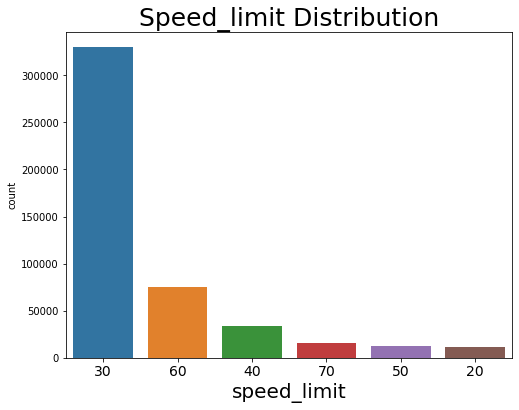

In [ ]:
count_plot(train,'speed_limit')

In [ ]:
train['speed_limit'].value_counts()

30    329800
60     75015
40     34108
70     16147
50     12257
20     11414
Name: speed_limit, dtype: int64

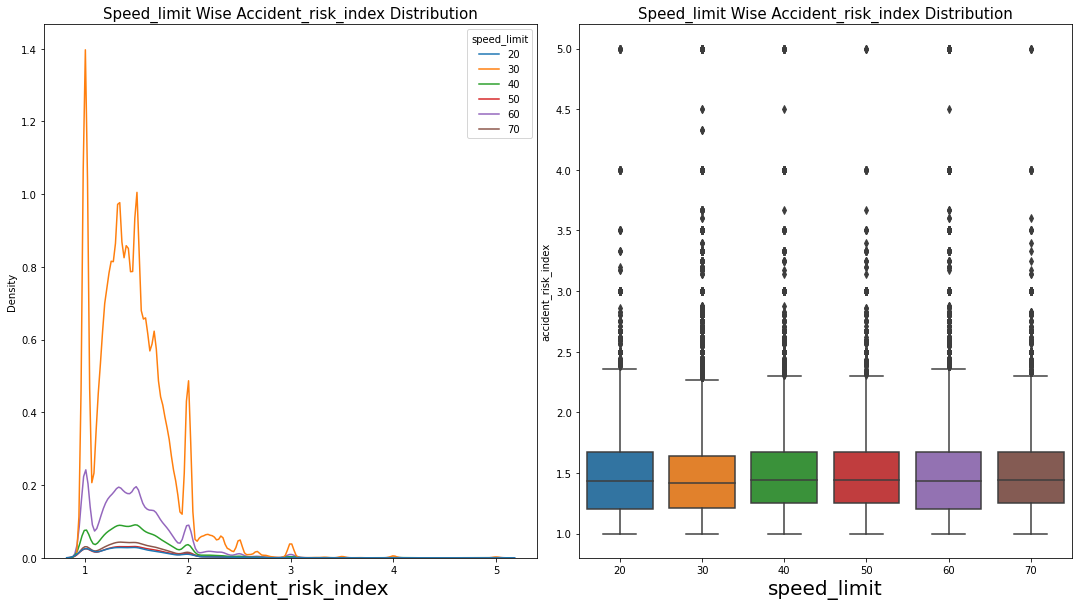

In [ ]:
side_by_side_plot(train,'speed_limit','accident_risk_index')

In [ ]:
group_summary(train,'speed_limit','accident_risk_index')

speed_limit     count      mean       std  min   25%   50%   75%  max
5           70   16147.0  1.490072  0.361573  1.0  1.25  1.44  1.67  5.0
3           50   12257.0  1.488402  0.374827  1.0  1.25  1.44  1.67  5.0
2           40   34108.0  1.488284  0.373265  1.0  1.25  1.44  1.67  5.0
0           20   11414.0  1.473661  0.392917  1.0  1.20  1.43  1.67  5.0
4           60   75015.0  1.472012  0.387058  1.0  1.20  1.43  1.67  5.0
1           30  329800.0  1.456334  0.351503  1.0  1.21  1.42  1.64  5.0

#### The above plot explains that in all area most of roads have 30mph speed limit.

#### The average accident risk index is almost the same in all speed limit category. 

### Let's compare the state-wise accident risk index by type of the road.

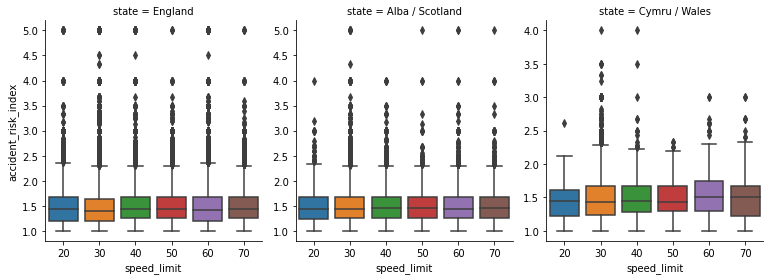

In [ ]:
sns.catplot(x='speed_limit',y='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','speed_limit'],'accident_risk_index')

state  speed_limit     count      mean       std  min    25%  \
10    Cymru / Wales           60     279.0  1.533584  0.369822  1.0  1.295   
5   Alba / Scotland           70    2288.0  1.504017  0.371938  1.0  1.250   
8     Cymru / Wales           40     488.0  1.495820  0.341757  1.0  1.285   
2   Alba / Scotland           40    4408.0  1.494027  0.352372  1.0  1.250   
11    Cymru / Wales           70     284.0  1.491937  0.368900  1.0  1.220   
15          England           50   10217.0  1.488751  0.380203  1.0  1.250   
17          England           70   13575.0  1.487683  0.359616  1.0  1.250   
14          England           40   29212.0  1.487292  0.376819  1.0  1.250   
9     Cymru / Wales           50     156.0  1.487179  0.298700  1.0  1.290   
3   Alba / Scotland           50    1884.0  1.486608  0.350486  1.0  1.250   
4   Alba / Scotland           60    4465.0  1.480625  0.368006  1.0  1.250   
0   Alba / Scotland           20    1232.0  1.476242  0.354509  1.0  1.230   
1   Alba / Scotland           30   45390.0  1.474132  0.344515  1.0  1.250   
12          England           20   10060.0  1.473791  0.398354  1.0  1.200   
16          England           60   70271.0  1.471220  0.388283  1.0  1.200   
7     Cymru / Wales           30    9892.0  1.460429  0.334772  1.0  1.240   
13          England           30  274518.0  1.453244  0.353144  1.0  1.200   
6     Cymru / Wales           20     122.0  1.436885  0.299785  1.0  1.220   

      50%     75%   max  
10  1.500  1.7500  3.00  
5   1.450  1.6750  5.00  
8   1.440  1.6700  4.00  
2   1.460  1.6700  4.00  
11  1.500  1.6700  3.00  
15  1.440  1.6700  5.00  
17  1.440  1.6700  5.00  
14  1.440  1.6700  5.00  
9   1.435  1.6700  2.33  
3   1.460  1.6700  5.00  
4   1.430  1.6700  5.00  
0   1.430  1.6700  4.00  
1   1.440  1.6700  5.00  
12  1.430  1.6700  5.00  
16  1.420  1.6700  5.00  
7   1.430  1.6700  4.00  
13  1.400  1.6400  5.00  
6   1.445  1.6175  2.62

#### The above plot explains that in all states the accident risk index is almost similar in all speed limit categoey.

### Let's see the speed limit of each road type.

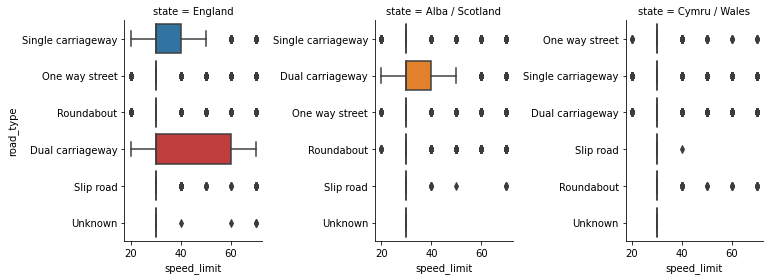

In [ ]:
sns.catplot(y='road_type',x='speed_limit',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

#### The above plot explains that the speed limit changes based on the road types in all states of the united kingdom. 

### Let's compare the state-wise total accident count by speed limit categoey.

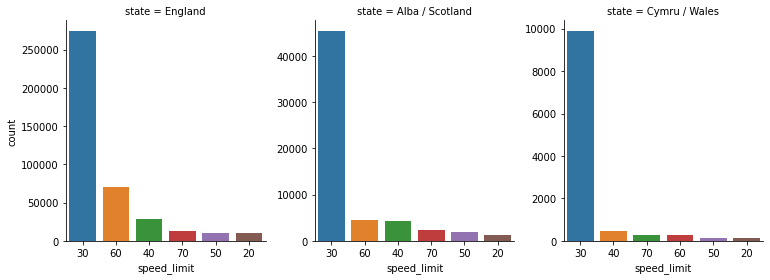

In [ ]:
sns.catplot(x='speed_limit',y='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'speed_limit':'str'}).groupby(['state','speed_limit'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'speed_limit':'str'}).groupby(['state','speed_limit'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state speed_limit   count
13          England          30  274518
16          England          60   70271
1   Alba / Scotland          30   45390
14          England          40   29212
17          England          70   13575
15          England          50   10217
12          England          20   10060
7     Cymru / Wales          30    9892
4   Alba / Scotland          60    4465
2   Alba / Scotland          40    4408
5   Alba / Scotland          70    2288
3   Alba / Scotland          50    1884
0   Alba / Scotland          20    1232
8     Cymru / Wales          40     488
11    Cymru / Wales          70     284
10    Cymru / Wales          60     279
9     Cymru / Wales          50     156
6     Cymru / Wales          20     122

#### Most of the accidents happened in 30mph speed limit roads and in the state of England.

### Let's compare the state-wise total accident casualties by speed limit category.

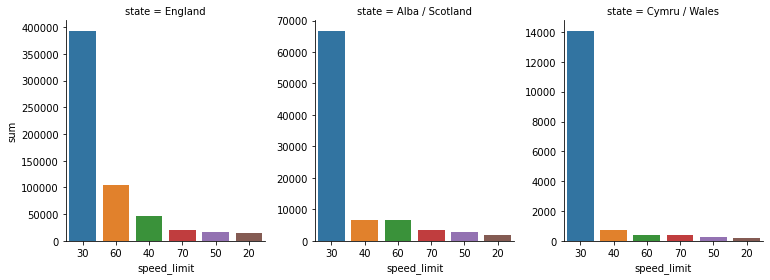

In [ ]:
sns.catplot(x='speed_limit',y='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'speed_limit':'str'}).groupby(['state','speed_limit'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'road_type':'str'}).groupby(['state','road_type'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state           road_type     sum
15          England  Single carriageway  471287
3   Alba / Scotland  Single carriageway   59159
12          England    Dual carriageway   54692
14          England          Roundabout   38865
13          England      One way street   30654
0   Alba / Scotland    Dual carriageway   21658
9     Cymru / Wales  Single carriageway   10872
1   Alba / Scotland      One way street    4129
2   Alba / Scotland          Roundabout    3434
6     Cymru / Wales    Dual carriageway    3181
7     Cymru / Wales      One way street    1367
8     Cymru / Wales          Roundabout     575
16          England           Slip road     562
4   Alba / Scotland           Slip road     112
10    Cymru / Wales           Slip road      57
17          England             Unknown      37
5   Alba / Scotland             Unknown       7
11    Cymru / Wales             Unknown       3

#### Most of the accident casualties happened in 30mph speed limit roads and in the state of England.

#### Let's see how the accident risk index changes on the 1st and 2nd road class types.

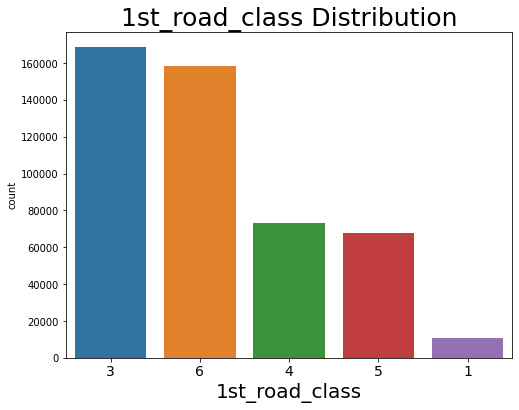

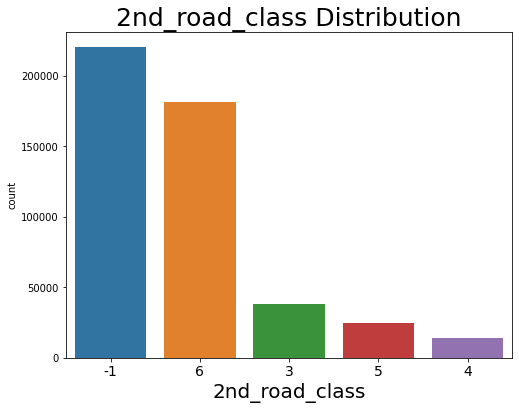

In [ ]:
count_plot(train,'1st_road_class')
count_plot(train,'2nd_road_class')

In [ ]:
train['1st_road_class'].value_counts()

3    168644
6    158212
4     73233
5     67709
1     10943
Name: 1st_road_class, dtype: int64

In [ ]:
train['2nd_road_class'].value_counts()

-1    220221
 6    181479
 3     38286
 5     24842
 4     13913
Name: 2nd_road_class, dtype: int64

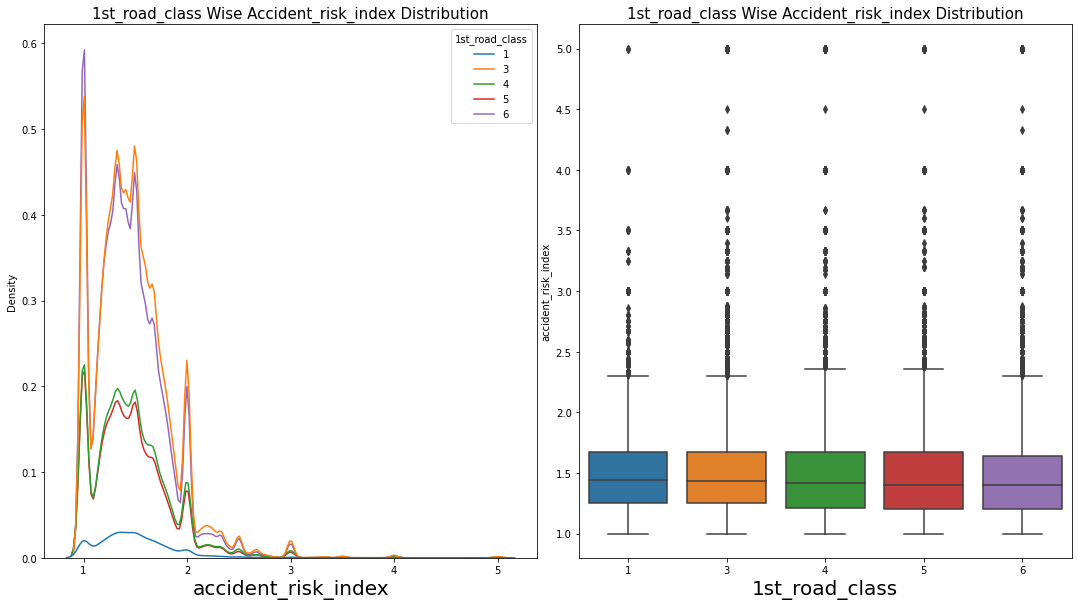

In [ ]:
side_by_side_plot(train,'1st_road_class','accident_risk_index')

In [ ]:
group_summary(train,'1st_road_class','accident_risk_index')

1st_road_class     count      mean       std  min   25%   50%   75%  max
0               1   10943.0  1.483247  0.352433  1.0  1.25  1.44  1.67  5.0
1               3  168644.0  1.477080  0.362230  1.0  1.25  1.43  1.67  5.0
2               4   73233.0  1.467079  0.372164  1.0  1.21  1.42  1.67  5.0
3               5   67709.0  1.455194  0.363510  1.0  1.20  1.40  1.67  5.0
4               6  158212.0  1.449372  0.353292  1.0  1.20  1.40  1.64  5.0

#### The average accident risk index is almost the same in all categories of 1st road class. 

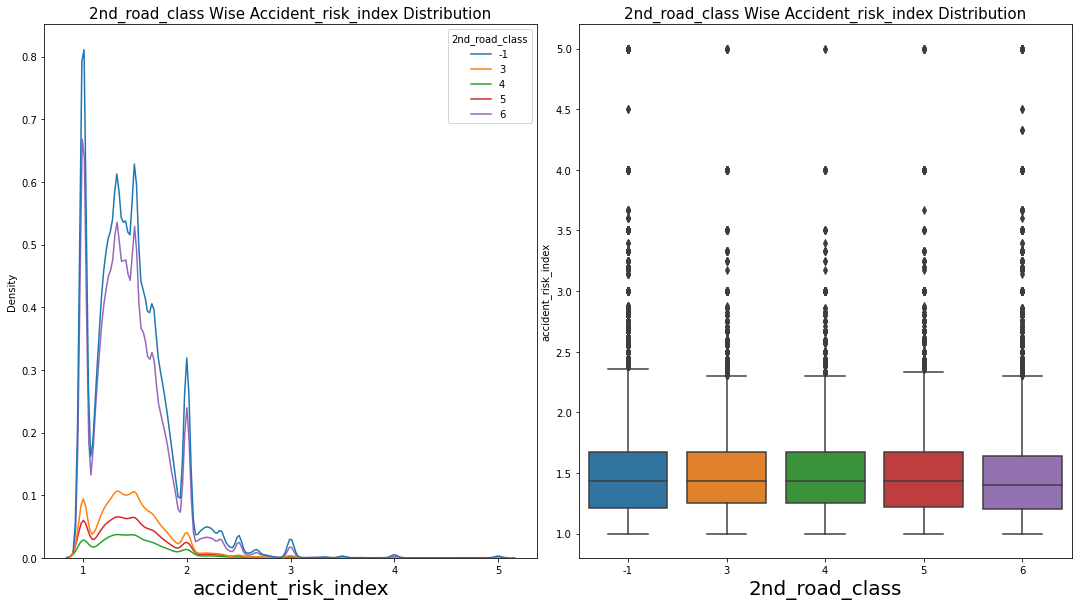

In [ ]:
side_by_side_plot(train,'2nd_road_class','accident_risk_index')

In [ ]:
group_summary(train,'2nd_road_class','accident_risk_index')

2nd_road_class     count      mean       std  min   25%   50%   75%  max
2               4   13913.0  1.477443  0.358946  1.0  1.25  1.43  1.67  5.0
3               5   24842.0  1.474159  0.370319  1.0  1.22  1.43  1.67  5.0
1               3   38286.0  1.473622  0.349656  1.0  1.25  1.43  1.67  5.0
0              -1  220221.0  1.469955  0.373509  1.0  1.21  1.43  1.67  5.0
4               6  181479.0  1.450842  0.346164  1.0  1.20  1.40  1.64  5.0

#### The average accident risk index is almost the same in all categories of 2nd road class. 

### Let's compare the state-wise accident risk index by type of 1st road class.

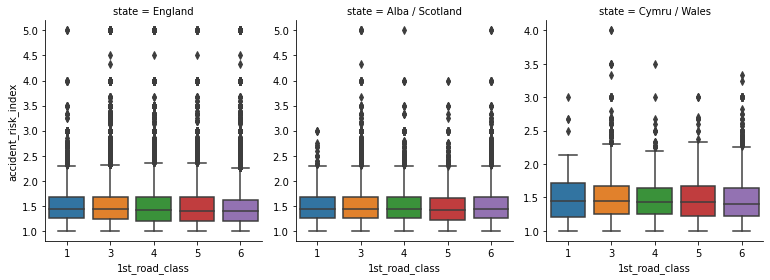

In [ ]:
sns.catplot(x='1st_road_class',y='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','1st_road_class'],'accident_risk_index')

state  1st_road_class     count      mean       std  min   25%  \
5     Cymru / Wales               1     101.0  1.504554  0.394329  1.0  1.21   
0   Alba / Scotland               1     641.0  1.485632  0.346917  1.0  1.25   
1   Alba / Scotland               3   29839.0  1.484771  0.351710  1.0  1.25   
2   Alba / Scotland               4    5021.0  1.484641  0.361038  1.0  1.25   
8     Cymru / Wales               5     528.0  1.483049  0.358942  1.0  1.23   
10          England               1   10201.0  1.482886  0.352368  1.0  1.25   
6     Cymru / Wales               3    5136.0  1.477175  0.339116  1.0  1.25   
11          England               3  133669.0  1.475359  0.365371  1.0  1.24   
4   Alba / Scotland               6   20365.0  1.468417  0.339914  1.0  1.25   
12          England               4   67419.0  1.465975  0.373490  1.0  1.20   
3   Alba / Scotland               5    3801.0  1.460963  0.349850  1.0  1.22   
13          England               5   63380.0  1.454616  0.364344  1.0  1.20   
9     Cymru / Wales               6    4663.0  1.450555  0.330861  1.0  1.22   
7     Cymru / Wales               4     793.0  1.449786  0.322606  1.0  1.25   
14          England               6  133184.0  1.446418  0.355960  1.0  1.20   

     50%   75%   max  
5   1.44  1.71  3.00  
0   1.43  1.67  3.00  
1   1.44  1.67  5.00  
2   1.44  1.67  5.00  
8   1.43  1.67  3.00  
10  1.44  1.67  5.00  
6   1.44  1.67  4.00  
11  1.43  1.67  5.00  
4   1.43  1.67  5.00  
12  1.42  1.67  5.00  
3   1.42  1.65  4.00  
13  1.40  1.67  5.00  
9   1.40  1.64  3.33  
7   1.43  1.64  3.50  
14  1.40  1.62  5.00

#### The above plot explains that in all states the accident risk index is almost similar in all categories of 1st road class.

### Let's compare the state-wise accident risk index by type of 2nd road class.

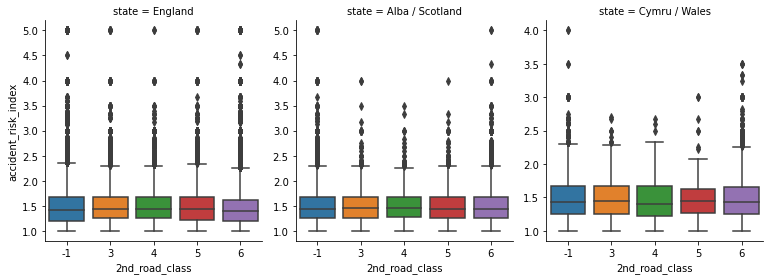

In [ ]:
sns.catplot(x='2nd_road_class',y='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','2nd_road_class'],'accident_risk_index')

state  2nd_road_class     count      mean       std  min    25%  \
8     Cymru / Wales               5     196.0  1.495102  0.344511  1.0  1.265   
2   Alba / Scotland               4     995.0  1.495015  0.339162  1.0  1.270   
3   Alba / Scotland               5    1565.0  1.493802  0.367859  1.0  1.250   
1   Alba / Scotland               3    2534.0  1.487593  0.342018  1.0  1.250   
0   Alba / Scotland              -1   34424.0  1.479540  0.352065  1.0  1.250   
6     Cymru / Wales               3     469.0  1.477356  0.322145  1.0  1.250   
12          England               4   12787.0  1.476097  0.360466  1.0  1.250   
7     Cymru / Wales               4     131.0  1.475420  0.355409  1.0  1.225   
13          England               5   23081.0  1.472649  0.370668  1.0  1.220   
11          England               3   35283.0  1.472570  0.350536  1.0  1.250   
4   Alba / Scotland               6   20149.0  1.471121  0.341810  1.0  1.250   
10          England              -1  181527.0  1.468194  0.378073  1.0  1.200   
5     Cymru / Wales              -1    4270.0  1.467527  0.343943  1.0  1.250   
9     Cymru / Wales               6    6155.0  1.460578  0.331294  1.0  1.250   
14          England               6  155175.0  1.447823  0.347207  1.0  1.200   

     50%   75%   max  
8   1.45  1.62  3.00  
2   1.46  1.67  3.50  
3   1.44  1.67  4.00  
1   1.45  1.67  4.00  
0   1.44  1.67  5.00  
6   1.45  1.67  2.71  
12  1.43  1.67  5.00  
7   1.40  1.67  2.67  
13  1.43  1.67  5.00  
11  1.43  1.67  5.00  
4   1.43  1.67  5.00  
10  1.42  1.67  5.00  
5   1.43  1.67  4.00  
9   1.43  1.65  3.50  
14  1.40  1.62  5.00

#### The above plot explains that in all states the accident risk index is almost similar in all categories of 2nd road class.

### Let's compare the state-wise total accident count by 1st road class.

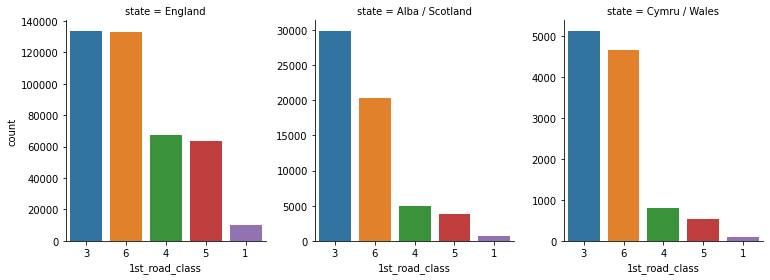

In [ ]:
sns.catplot(x='1st_road_class',y='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'1st_road_class':'str'}).groupby(['state','1st_road_class'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'1st_road_class':'str'}).groupby(['state','1st_road_class'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state 1st_road_class   count
11          England              3  133669
14          England              6  133184
12          England              4   67419
13          England              5   63380
1   Alba / Scotland              3   29839
4   Alba / Scotland              6   20365
10          England              1   10201
6     Cymru / Wales              3    5136
2   Alba / Scotland              4    5021
9     Cymru / Wales              6    4663
3   Alba / Scotland              5    3801
7     Cymru / Wales              4     793
0   Alba / Scotland              1     641
8     Cymru / Wales              5     528
5     Cymru / Wales              1     101

#### Most of the accidents happened in road class 3, 6 and in the state of England.

### Let's compare the state-wise total accident count by 2nd road class.

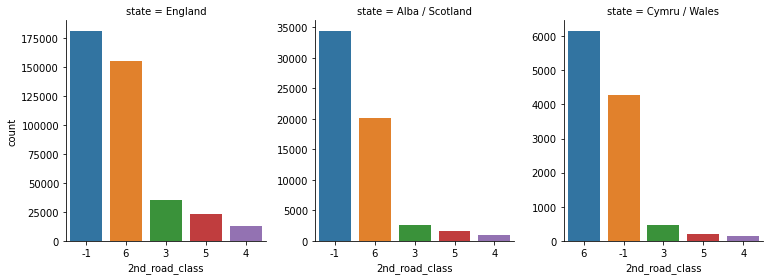

In [ ]:
sns.catplot(x='2nd_road_class',y='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'2nd_road_class':'str'}).groupby(['state','2nd_road_class'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'2nd_road_class':'str'}).groupby(['state','2nd_road_class'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state 2nd_road_class   count
10          England             -1  181527
14          England              6  155175
11          England              3   35283
0   Alba / Scotland             -1   34424
13          England              5   23081
4   Alba / Scotland              6   20149
12          England              4   12787
9     Cymru / Wales              6    6155
5     Cymru / Wales             -1    4270
1   Alba / Scotland              3    2534
3   Alba / Scotland              5    1565
2   Alba / Scotland              4     995
6     Cymru / Wales              3     469
8     Cymru / Wales              5     196
7     Cymru / Wales              4     131

#### Most of the accidents happened in road class -1, 6 and in all the states of the United Kingdom.

### Let's compare the state-wise total accident casualties by 1st road class.

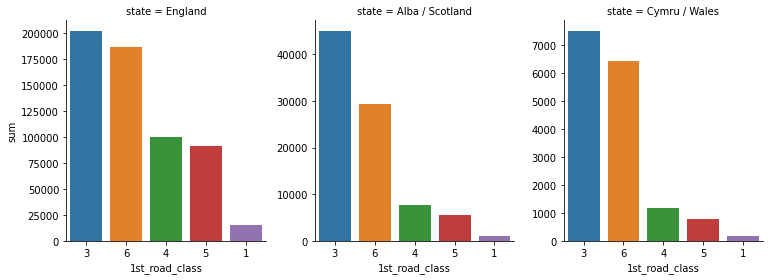

In [ ]:
sns.catplot(x='1st_road_class',y='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'1st_road_class':'str'}).groupby(['state','1st_road_class'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'1st_road_class':'str'}).groupby(['state','1st_road_class'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state 1st_road_class     sum
11          England              3  202225
14          England              6  187064
12          England              4   99838
13          England              5   91500
1   Alba / Scotland              3   45040
4   Alba / Scotland              6   29269
10          England              1   15470
2   Alba / Scotland              4    7617
6     Cymru / Wales              3    7500
9     Cymru / Wales              6    6436
3   Alba / Scotland              5    5596
7     Cymru / Wales              4    1172
0   Alba / Scotland              1     977
8     Cymru / Wales              5     770
5     Cymru / Wales              1     177

#### Most of the accident casualties happened in 1st road classes 3, 6, and in all states of the united kingdom.

### Let's compare the state-wise total accident casualties by 2nd road class.

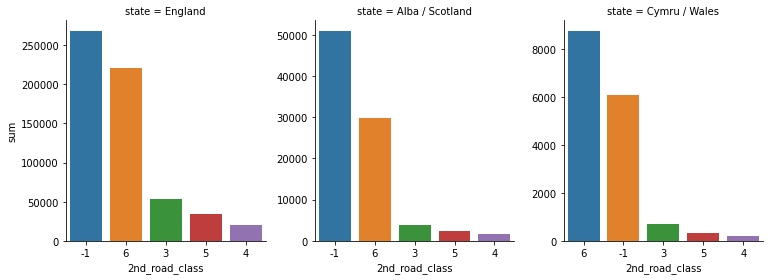

In [ ]:
sns.catplot(x='2nd_road_class',y='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'2nd_road_class':'str'}).groupby(['state','2nd_road_class'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'2nd_road_class':'str'}).groupby(['state','2nd_road_class'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state 2nd_road_class     sum
10          England             -1  267905
14          England              6  220277
11          England              3   53178
0   Alba / Scotland             -1   50931
13          England              5   34911
4   Alba / Scotland              6   29796
12          England              4   19826
9     Cymru / Wales              6    8743
5     Cymru / Wales             -1    6075
1   Alba / Scotland              3    3788
3   Alba / Scotland              5    2429
2   Alba / Scotland              4    1555
6     Cymru / Wales              3     716
8     Cymru / Wales              5     317
7     Cymru / Wales              4     204

#### Most of the accident casualties happened in 2nd road classes -1, 6, and in all states of the united kingdom.

#### Let's see whether the pedestrian crossing human control system will reduce the road accident risk index?

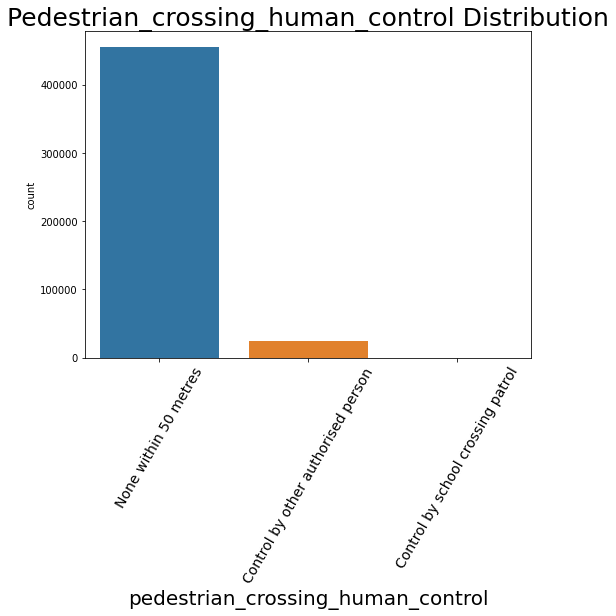

In [ ]:
count_plot(train,'pedestrian_crossing_human_control',rot=60)

In [ ]:
train['pedestrian_crossing_human_control'].value_counts()

None within 50 metres                 455040
Control by other authorised person     23669
Control by school crossing patrol         32
Name: pedestrian_crossing_human_control, dtype: int64

#### Most road pedestrian crossing doesn't have any human control system facility. If it's present it's mostly controlled by the authorized person.

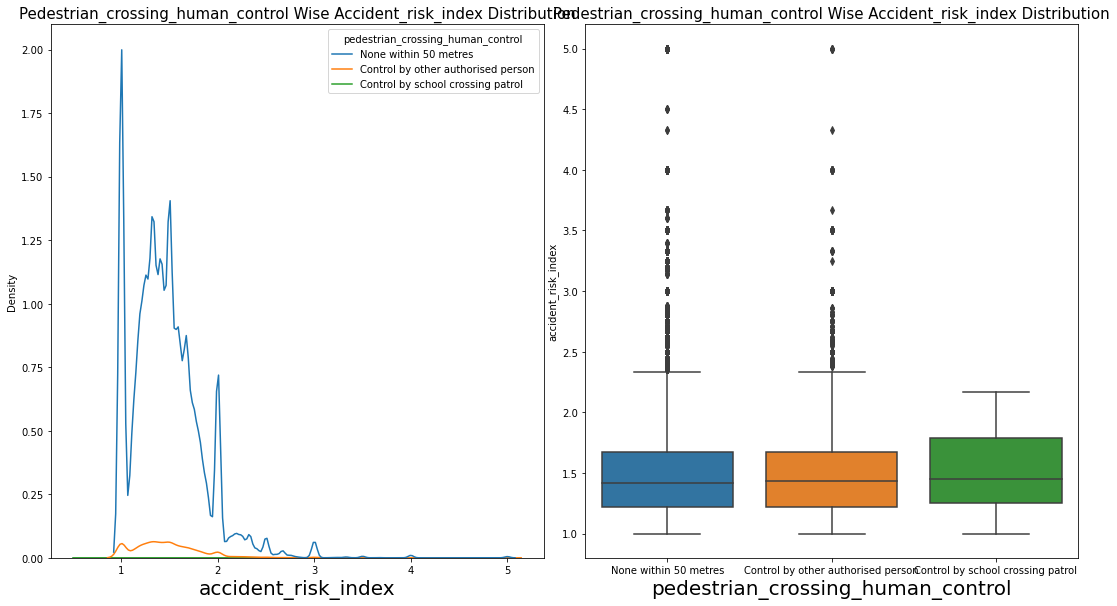

In [ ]:
side_by_side_plot(train,'pedestrian_crossing_human_control','accident_risk_index')

In [ ]:
group_summary(train,'pedestrian_crossing_human_control','accident_risk_index')

pedestrian_crossing_human_control     count      mean       std  min  \
1   Control by school crossing patrol      32.0  1.478438  0.334463  1.0   
0  Control by other authorised person   23669.0  1.468792  0.358576  1.0   
2               None within 50 metres  455040.0  1.463159  0.361146  1.0   

    25%   50%    75%   max  
1  1.25  1.45  1.785  2.17  
0  1.22  1.43  1.670  5.00  
2  1.22  1.42  1.670  5.00

#### There is no significant correlation between the average accident risk index and the road which have pedestrian crossing human control facility.

### Let's compare the state-wise accident risk index with pedestrian crossing human control system facility.

In [ ]:
sns.catplot(y='pedestrian_crossing_human_control',x='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','pedestrian_crossing_human_control'],'accident_risk_index')

state   pedestrian_crossing_human_control     count      mean  \
0  Alba / Scotland  Control by other authorised person    2844.0  1.493070   
7          England   Control by school crossing patrol      25.0  1.490000   
2  Alba / Scotland               None within 50 metres   56817.0  1.476901   
3    Cymru / Wales  Control by other authorised person     439.0  1.466743   
6          England  Control by other authorised person   20386.0  1.465449   
1  Alba / Scotland   Control by school crossing patrol       6.0  1.465000   
5    Cymru / Wales               None within 50 metres   10781.0  1.464635   
8          England               None within 50 metres  387442.0  1.461103   
4    Cymru / Wales   Control by school crossing patrol       1.0  1.270000   

        std   min     25%   50%   75%   max  
0  0.349078  1.00  1.2500  1.45  1.67  4.33  
7  0.361444  1.00  1.2500  1.56  1.80  2.17  
2  0.348426  1.00  1.2500  1.44  1.67  5.00  
3  0.294334  1.00  1.2500  1.44  1.67  2.67  
6  0.361018  1.00  1.2200  1.43  1.67  5.00  
1  0.238558  1.29  1.3375  1.37  1.47  1.93  
5  0.337925  1.00  1.2500  1.43  1.67  4.00  
8  0.363553  1.00  1.2000  1.42  1.67  5.00  
4       NaN  1.27  1.2700  1.27  1.27  1.27

#### The above plot explains that in all states the accident risk index is almost similar whether the road has pedestrian crossing system or not.

### Let's compare the state-wise total accident count by pedestrian crossing system.

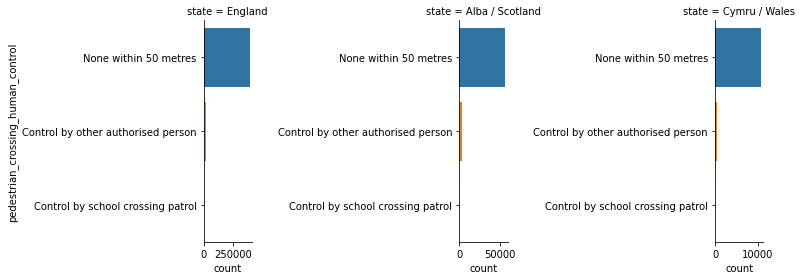

In [ ]:
sns.catplot(y='pedestrian_crossing_human_control',x='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'pedestrian_crossing_human_control':'str'}).groupby(['state','pedestrian_crossing_human_control'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'pedestrian_crossing_human_control':'str'}).groupby(['state','pedestrian_crossing_human_control'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state   pedestrian_crossing_human_control   count
8          England               None within 50 metres  387442
2  Alba / Scotland               None within 50 metres   56817
6          England  Control by other authorised person   20386
5    Cymru / Wales               None within 50 metres   10781
0  Alba / Scotland  Control by other authorised person    2844
3    Cymru / Wales  Control by other authorised person     439
7          England   Control by school crossing patrol      25
1  Alba / Scotland   Control by school crossing patrol       6
4    Cymru / Wales   Control by school crossing patrol       1

#### In all the states of the united kingdom, the area which doesn't have a pedestrian crossing human control system is the high accident area.

### Let's compare the state-wise total accident casualties by pedestrian crossing human system.

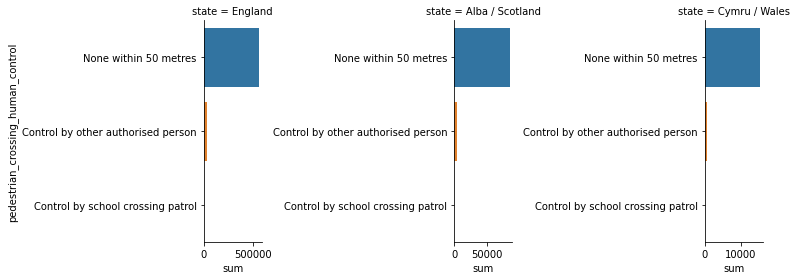

In [ ]:
sns.catplot(y='pedestrian_crossing_human_control',x='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'pedestrian_crossing_human_control':'str'}).groupby(['state','pedestrian_crossing_human_control'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'pedestrian_crossing_human_control':'str'}).groupby(['state','pedestrian_crossing_human_control'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state   pedestrian_crossing_human_control     sum
8          England               None within 50 metres  566040
2  Alba / Scotland               None within 50 metres   84167
6          England  Control by other authorised person   30020
5    Cymru / Wales               None within 50 metres   15398
0  Alba / Scotland  Control by other authorised person    4323
3    Cymru / Wales  Control by other authorised person     656
7          England   Control by school crossing patrol      37
1  Alba / Scotland   Control by school crossing patrol       9
4    Cymru / Wales   Control by school crossing patrol       1

#### In all the states of the united kingdom, the area which doesn't have a pedestrian crossing human control system is the high accident casualties area.

#### Let's see whether the pedestrian crossing physical facilities will reduce the road accident risk index?

In [ ]:
count_plot(train,'pedestrian_crossing_physical_facilities',rot=80)

In [ ]:
train['pedestrian_crossing_physical_facilities'].value_counts()

No physical crossing within 50 meters          404561
Pedestrian phase at traffic signal junction     35618
Zebra crossing                                  27007
non-junction pedestrian crossing                 9659
Central refuge                                   1834
Footbridge or subway                               62
Name: pedestrian_crossing_physical_facilities, dtype: int64

#### Most roads don't have a physical pedestrian crossing facility.

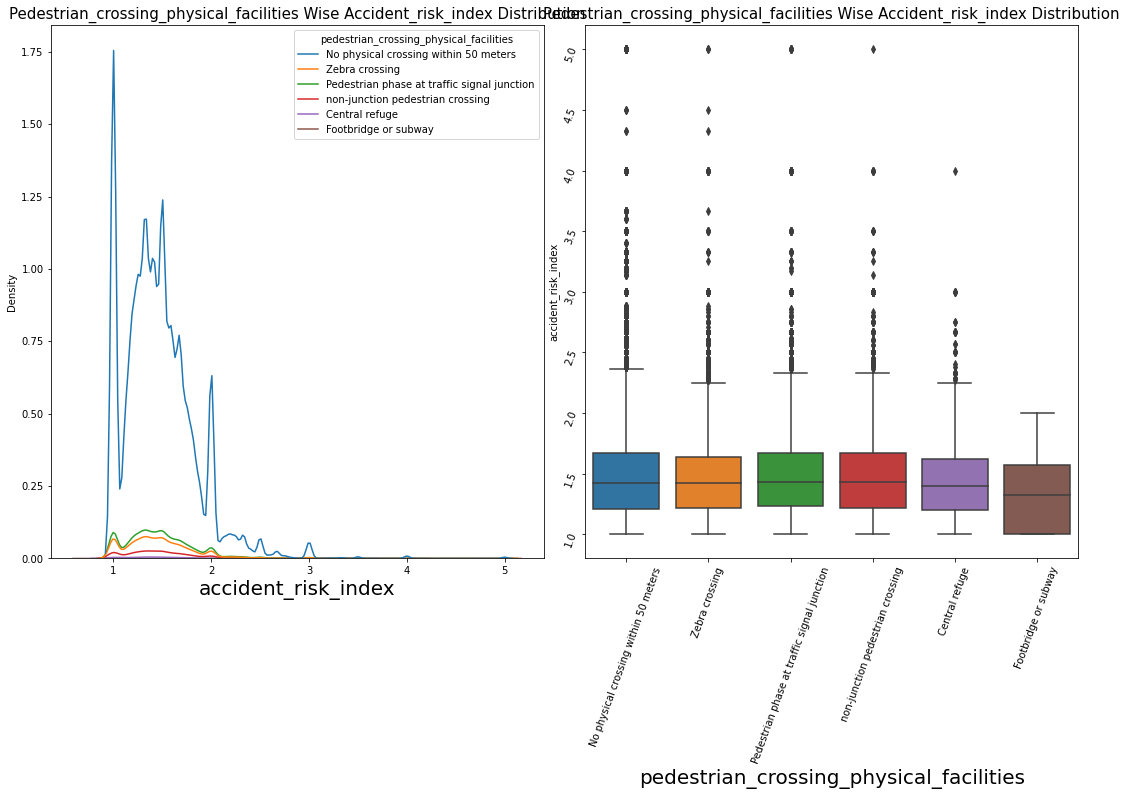

In [ ]:
side_by_side_plot(train,'pedestrian_crossing_physical_facilities','accident_risk_index',rot=70)

In [ ]:
group_summary(train,'pedestrian_crossing_physical_facilities','accident_risk_index')

pedestrian_crossing_physical_facilities     count      mean       std  \
3  Pedestrian phase at traffic signal junction   35618.0  1.468433  0.356279   
5             non-junction pedestrian crossing    9659.0  1.464029  0.351938   
2        No physical crossing within 50 meters  404561.0  1.463392  0.362529   
4                               Zebra crossing   27007.0  1.459132  0.348651   
0                               Central refuge    1834.0  1.440780  0.344193   
1                         Footbridge or subway      62.0  1.354355  0.315120   

   min   25%   50%   75%  max  
3  1.0  1.23  1.43  1.67  5.0  
5  1.0  1.22  1.43  1.67  5.0  
2  1.0  1.21  1.42  1.67  5.0  
4  1.0  1.22  1.42  1.64  5.0  
0  1.0  1.20  1.40  1.62  4.0  
1  1.0  1.00  1.32  1.57  2.0

#### There is no significant correlation between the average accident risk index and the road which have pedestrian crossing human control facility. But if the road has a footbridge or subway the accident risk index is very low when compared to other pedestrian crossing facilities.

### Let's compare the state-wise accident risk index with pedestrian crossing physical facilities.

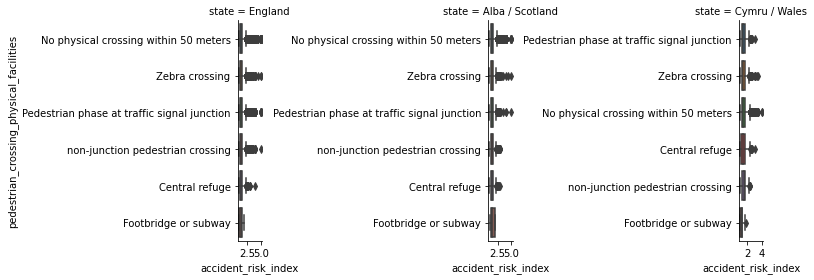

In [ ]:
sns.catplot(y='pedestrian_crossing_physical_facilities',x='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','pedestrian_crossing_physical_facilities'],'accident_risk_index')

state      pedestrian_crossing_physical_facilities     count  \
1   Alba / Scotland                         Footbridge or subway       7.0   
11    Cymru / Wales             non-junction pedestrian crossing     135.0   
3   Alba / Scotland  Pedestrian phase at traffic signal junction    3479.0   
4   Alba / Scotland                               Zebra crossing    4678.0   
2   Alba / Scotland        No physical crossing within 50 meters   49792.0   
9     Cymru / Wales  Pedestrian phase at traffic signal junction     732.0   
5   Alba / Scotland             non-junction pedestrian crossing    1366.0   
15          England  Pedestrian phase at traffic signal junction   31407.0   
8     Cymru / Wales        No physical crossing within 50 meters    8700.0   
17          England             non-junction pedestrian crossing    8158.0   
14          England        No physical crossing within 50 meters  346069.0   
16          England                               Zebra crossing   20976.0   
10    Cymru / Wales                               Zebra crossing    1353.0   
6     Cymru / Wales                               Central refuge     285.0   
12          England                               Central refuge    1204.0   
0   Alba / Scotland                               Central refuge     345.0   
13          England                         Footbridge or subway      39.0   
7     Cymru / Wales                         Footbridge or subway      16.0   

        mean       std   min    25%    50%    75%   max  
1   1.577143  0.392968  1.14  1.215  1.570  1.950  2.00  
11  1.506000  0.311036  1.00  1.315  1.500  1.670  2.40  
3   1.481107  0.345729  1.00  1.250  1.440  1.670  5.00  
4   1.478431  0.349252  1.00  1.250  1.430  1.670  5.00  
2   1.477918  0.349253  1.00  1.250  1.440  1.670  5.00  
9   1.475383  0.321654  1.00  1.250  1.440  1.670  3.00  
5   1.466977  0.326926  1.00  1.250  1.440  1.640  3.00  
15  1.466867  0.358173  1.00  1.230  1.430  1.670  5.00  
8   1.466522  0.337847  1.00  1.250  1.430  1.670  4.00  
17  1.462841  0.356574  1.00  1.220  1.430  1.670  5.00  
14  1.461223  0.364948  1.00  1.200  1.420  1.670  5.00  
16  1.455416  0.349481  1.00  1.220  1.420  1.640  5.00  
10  1.450015  0.331232  1.00  1.230  1.420  1.620  3.50  
6   1.444000  0.359251  1.00  1.200  1.400  1.670  3.00  
12  1.441013  0.344563  1.00  1.200  1.400  1.620  4.00  
0   1.437304  0.330910  1.00  1.220  1.400  1.600  3.00  
13  1.358205  0.308382  1.00  1.000  1.330  1.565  2.00  
7   1.247500  0.256424  1.00  1.000  1.235  1.330  1.83

#### The above plot explains that in all states the accident risk index is almost similar if the road has a physical pedestrian crossing facility or not. Except for footbridge or subway crossing facility.

### Let's compare the state-wise total accident count by pedestrian crossing facility.

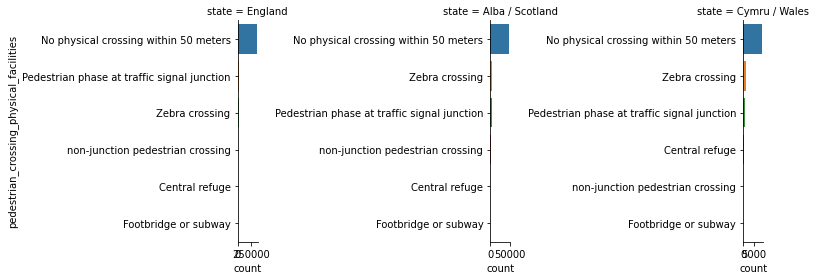

In [ ]:
sns.catplot(y='pedestrian_crossing_physical_facilities',x='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'pedestrian_crossing_physical_facilities':'str'}).groupby(['state','pedestrian_crossing_physical_facilities'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'pedestrian_crossing_physical_facilities':'str'}).groupby(['state','pedestrian_crossing_physical_facilities'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state      pedestrian_crossing_physical_facilities   count
14          England        No physical crossing within 50 meters  346069
2   Alba / Scotland        No physical crossing within 50 meters   49792
15          England  Pedestrian phase at traffic signal junction   31407
16          England                               Zebra crossing   20976
8     Cymru / Wales        No physical crossing within 50 meters    8700
17          England             non-junction pedestrian crossing    8158
4   Alba / Scotland                               Zebra crossing    4678
3   Alba / Scotland  Pedestrian phase at traffic signal junction    3479
5   Alba / Scotland             non-junction pedestrian crossing    1366
10    Cymru / Wales                               Zebra crossing    1353
12          England                               Central refuge    1204
9     Cymru / Wales  Pedestrian phase at traffic signal junction     732
0   Alba / Scotland                               Central refuge     345
6     Cymru / Wales                               Central refuge     285
11    Cymru / Wales             non-junction pedestrian crossing     135
13          England                         Footbridge or subway      39
7     Cymru / Wales                         Footbridge or subway      16
1   Alba / Scotland                         Footbridge or subway       7

#### In all the states of the united kingdom, the area which doesn't have a pedestrian crossing facility is the high accident area.

### Let's compare the state-wise total accident casualties by pedestrian crossing facility.

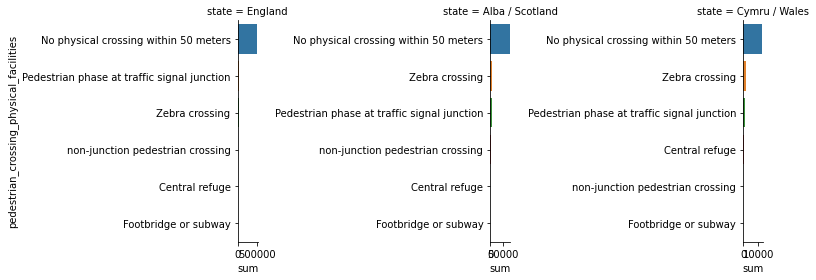

In [ ]:
sns.catplot(y='pedestrian_crossing_physical_facilities',x='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'pedestrian_crossing_physical_facilities':'str'}).groupby(['state','pedestrian_crossing_physical_facilities'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'pedestrian_crossing_physical_facilities':'str'}).groupby(['state','pedestrian_crossing_physical_facilities'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state      pedestrian_crossing_physical_facilities     sum
14          England        No physical crossing within 50 meters  505704
2   Alba / Scotland        No physical crossing within 50 meters   73886
15          England  Pedestrian phase at traffic signal junction   46497
16          England                               Zebra crossing   30411
8     Cymru / Wales        No physical crossing within 50 meters   12493
17          England             non-junction pedestrian crossing   11805
4   Alba / Scotland                               Zebra crossing    6910
3   Alba / Scotland  Pedestrian phase at traffic signal junction    5223
5   Alba / Scotland             non-junction pedestrian crossing    1976
10    Cymru / Wales                               Zebra crossing    1935
12          England                               Central refuge    1629
9     Cymru / Wales  Pedestrian phase at traffic signal junction    1031
0   Alba / Scotland                               Central refuge     490
6     Cymru / Wales                               Central refuge     381
11    Cymru / Wales             non-junction pedestrian crossing     193
13          England                         Footbridge or subway      51
7     Cymru / Wales                         Footbridge or subway      22
1   Alba / Scotland                         Footbridge or subway      14

#### In all the states of the united kingdom, the area which doesn't have a pedestrian crossing facility is the high accident casualties area.

#### Let's see road's lighting condition and accident risk index.

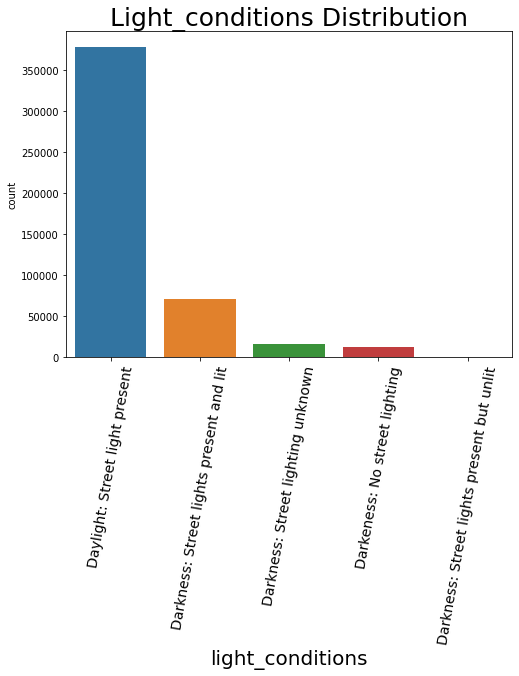

In [ ]:
count_plot(train,'light_conditions',rot=80)

In [ ]:
train['light_conditions'].value_counts()

Daylight: Street light present               377728
Darkness: Street lights present and lit       70860
Darkness: Street lighting unknown             16817
Darkeness: No street lighting                 13152
Darkness: Street lights present but unlit       184
Name: light_conditions, dtype: int64

#### Most of the accidents happened in daylight.

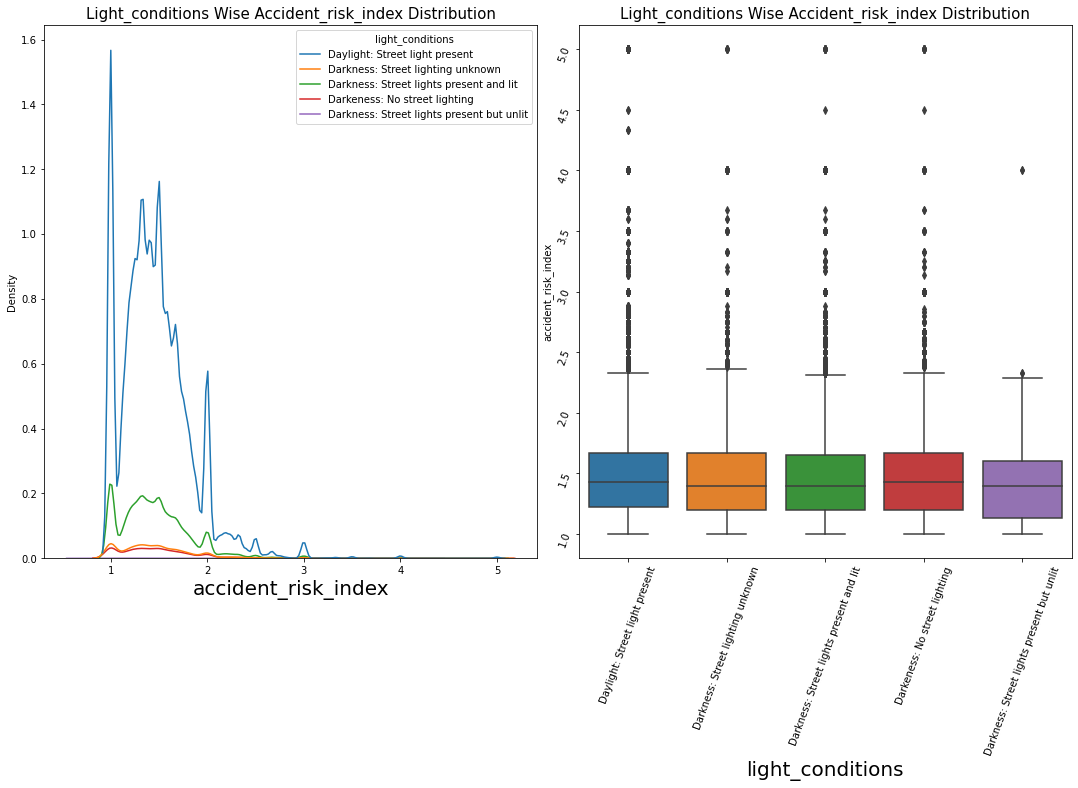

In [ ]:
side_by_side_plot(train,'light_conditions','accident_risk_index',rot=70)

In [ ]:
group_summary(train,'light_conditions','accident_risk_index')

light_conditions     count      mean       std  \
0              Darkeness: No street lighting   13152.0  1.476879  0.411361   
1          Darkness: Street lighting unknown   16817.0  1.466232  0.398430   
4             Daylight: Street light present  377728.0  1.464526  0.357834   
2    Darkness: Street lights present and lit   70860.0  1.454535  0.358223   
3  Darkness: Street lights present but unlit     184.0  1.444402  0.431520   

   min     25%   50%   75%  max  
0  1.0  1.2000  1.43  1.67  5.0  
1  1.0  1.2000  1.40  1.67  5.0  
4  1.0  1.2200  1.43  1.67  5.0  
2  1.0  1.2000  1.40  1.65  5.0  
3  1.0  1.1325  1.40  1.60  4.0

#### There is no significant correlation between the average accident risk index and the road's lighting condition. 

### Let's compare the state-wise accident risk index with light conditions.

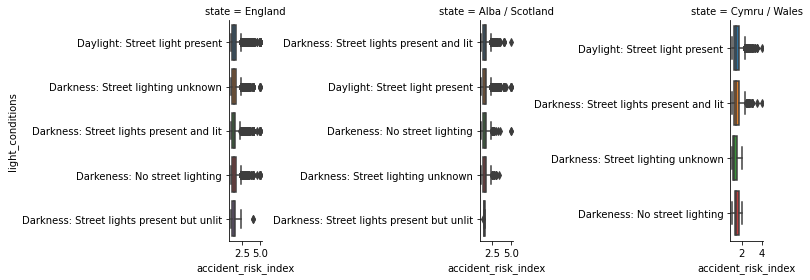

In [ ]:
sns.catplot(y='light_conditions',x='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','light_conditions'],'accident_risk_index')

state                           light_conditions     count  \
0   Alba / Scotland              Darkeness: No street lighting     846.0   
5     Cymru / Wales              Darkeness: No street lighting      30.0   
1   Alba / Scotland          Darkness: Street lighting unknown     651.0   
4   Alba / Scotland             Daylight: Street light present   47244.0   
9           England              Darkeness: No street lighting   12276.0   
2   Alba / Scotland    Darkness: Street lights present and lit   10922.0   
7     Cymru / Wales    Darkness: Street lights present and lit    2111.0   
10          England          Darkness: Street lighting unknown   16155.0   
8     Cymru / Wales             Daylight: Street light present    9069.0   
13          England             Daylight: Street light present  321415.0   
11          England    Darkness: Street lights present and lit   57827.0   
12          England  Darkness: Street lights present but unlit     180.0   
3   Alba / Scotland  Darkness: Street lights present but unlit       4.0   
6     Cymru / Wales          Darkness: Street lighting unknown      11.0   

        mean       std   min     25%   50%    75%   max  
0   1.511596  0.402460  1.00  1.2500  1.50  1.690  5.00  
5   1.495000  0.297678  1.00  1.2700  1.45  1.750  2.00  
1   1.479570  0.383160  1.00  1.2000  1.43  1.670  3.33  
4   1.479054  0.346696  1.00  1.2500  1.44  1.670  5.00  
9   1.474442  0.412122  1.00  1.2000  1.42  1.670  5.00  
2   1.468981  0.349253  1.00  1.2500  1.43  1.670  5.00  
7   1.466570  0.351729  1.00  1.2300  1.43  1.670  4.00  
10  1.465795  0.399061  1.00  1.2000  1.40  1.670  5.00  
8   1.464341  0.332735  1.00  1.2500  1.43  1.670  4.00  
13  1.462396  0.360073  1.00  1.2200  1.42  1.670  5.00  
11  1.451368  0.360056  1.00  1.2000  1.40  1.640  5.00  
12  1.445889  0.435915  1.00  1.1100  1.40  1.605  4.00  
3   1.377500  0.121209  1.21  1.3525  1.40  1.425  1.50  
6   1.319091  0.342446  1.00  1.0600  1.17  1.550  2.00

#### The above plot explains that in all states the accident risk index is almost similar if the light condition is darker or daylight. Except for the lighting condition darkness without light.

### Let's compare the state-wise total accident count by light condition.

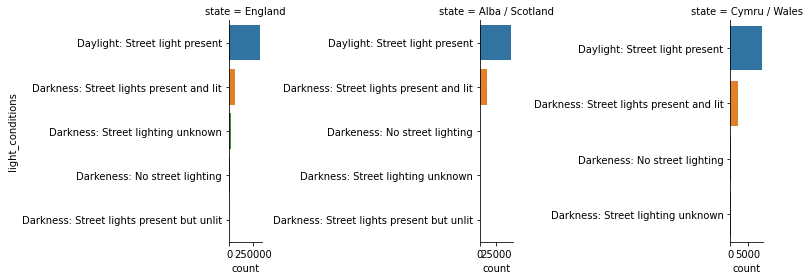

In [ ]:
sns.catplot(y='light_conditions',x='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'light_conditions':'str'}).groupby(['state','light_conditions'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'light_conditions':'str'}).groupby(['state','light_conditions'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state                           light_conditions   count
13          England             Daylight: Street light present  321415
11          England    Darkness: Street lights present and lit   57827
4   Alba / Scotland             Daylight: Street light present   47244
10          England          Darkness: Street lighting unknown   16155
9           England              Darkeness: No street lighting   12276
2   Alba / Scotland    Darkness: Street lights present and lit   10922
8     Cymru / Wales             Daylight: Street light present    9069
7     Cymru / Wales    Darkness: Street lights present and lit    2111
0   Alba / Scotland              Darkeness: No street lighting     846
1   Alba / Scotland          Darkness: Street lighting unknown     651
12          England  Darkness: Street lights present but unlit     180
5     Cymru / Wales              Darkeness: No street lighting      30
6     Cymru / Wales          Darkness: Street lighting unknown      11
3   Alba / Scotland  Darkness: Street lights present but unlit       4

#### In all the states of the united kingdom,   higher number of accidents in daylight, and darkness.

### Let's compare the state-wise total accident casualties by light condition.

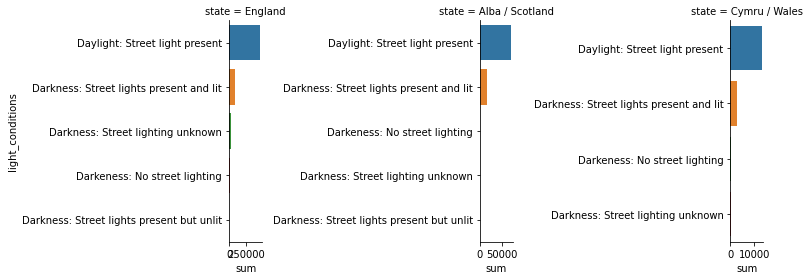

In [ ]:
sns.catplot(y='light_conditions',x='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'light_conditions':'str'}).groupby(['state','light_conditions'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'light_conditions':'str'}).groupby(['state','light_conditions'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state                           light_conditions     sum
13          England             Daylight: Street light present  471027
11          England    Darkness: Street lights present and lit   82462
4   Alba / Scotland             Daylight: Street light present   70297
10          England          Darkness: Street lighting unknown   23895
9           England              Darkeness: No street lighting   18450
2   Alba / Scotland    Darkness: Street lights present and lit   15910
8     Cymru / Wales             Daylight: Street light present   13080
7     Cymru / Wales    Darkness: Street lights present and lit    2917
0   Alba / Scotland              Darkeness: No street lighting    1317
1   Alba / Scotland          Darkness: Street lighting unknown     971
12          England  Darkness: Street lights present but unlit     263
5     Cymru / Wales              Darkeness: No street lighting      40
6     Cymru / Wales          Darkness: Street lighting unknown      18
3   Alba / Scotland  Darkness: Street lights present but unlit       4

#### In all the states of the united kingdom,   higher number of accident casualties in daylight, and darkness.

#### Let's see road's lighting condition and accident risk index.

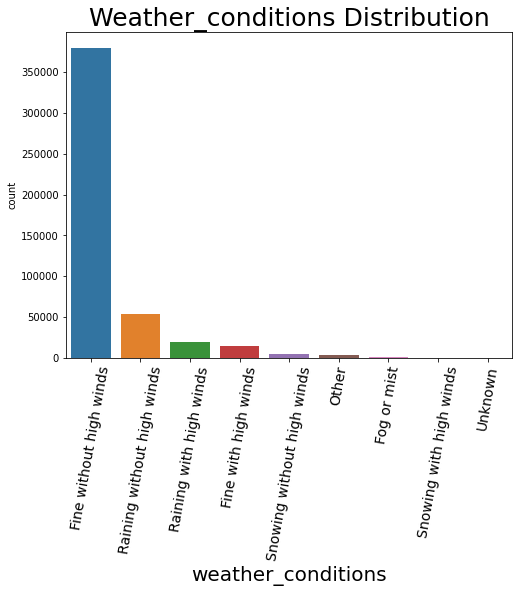

In [ ]:
count_plot(train,'weather_conditions',rot=80)

In [ ]:
train['weather_conditions'].value_counts()

Fine without high winds       379429
Raining without high winds     53708
Raining with high winds        20326
Fine with high winds           14714
Snowing without high winds      4608
Other                           4531
Fog or mist                     1058
Snowing with high winds          249
Unknown                          118
Name: weather_conditions, dtype: int64

#### Fine weather conditions recorded the most number of accidents.

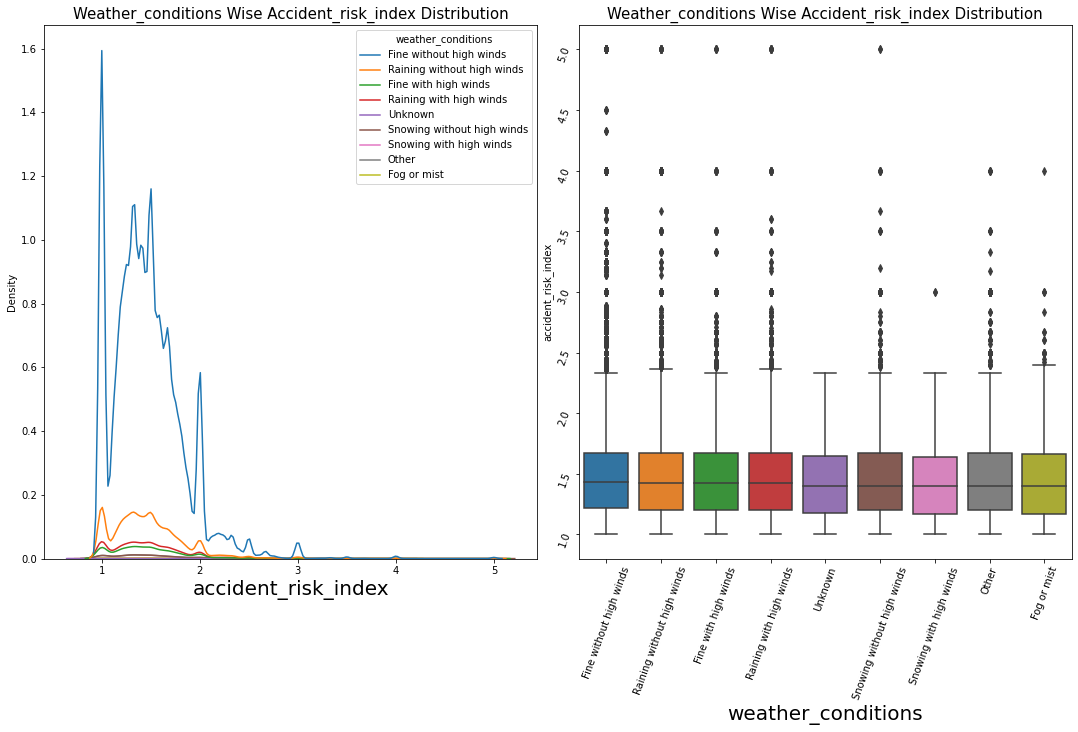

In [ ]:
side_by_side_plot(train,'weather_conditions','accident_risk_index',rot=70)

In [ ]:
group_summary(train,'weather_conditions','accident_risk_index')

weather_conditions     count      mean       std  min   25%   50%  \
0        Fine with high winds   14714.0  1.467920  0.378880  1.0  1.20  1.42   
1     Fine without high winds  379429.0  1.464381  0.359667  1.0  1.22  1.43   
4     Raining with high winds   20326.0  1.462544  0.372007  1.0  1.20  1.42   
7  Snowing without high winds    4608.0  1.459889  0.382946  1.0  1.20  1.40   
5  Raining without high winds   53708.0  1.457375  0.357708  1.0  1.20  1.42   
3                       Other    4531.0  1.457085  0.379318  1.0  1.20  1.40   
2                 Fog or mist    1058.0  1.442817  0.369783  1.0  1.17  1.40   
6     Snowing with high winds     249.0  1.434538  0.346489  1.0  1.17  1.40   
8                     Unknown     118.0  1.419153  0.309669  1.0  1.18  1.40   

      75%   max  
0  1.6700  5.00  
1  1.6700  5.00  
4  1.6700  5.00  
7  1.6700  5.00  
5  1.6700  5.00  
3  1.6700  4.00  
2  1.6650  4.00  
6  1.6400  3.00  
8  1.6475  2.33

#### There is no significant correlation between the average accident risk index and the weather condition. But the accident risk index is low on snowy and high wind weather conditions.

### Let's compare the state-wise accident risk index with weather conditions.

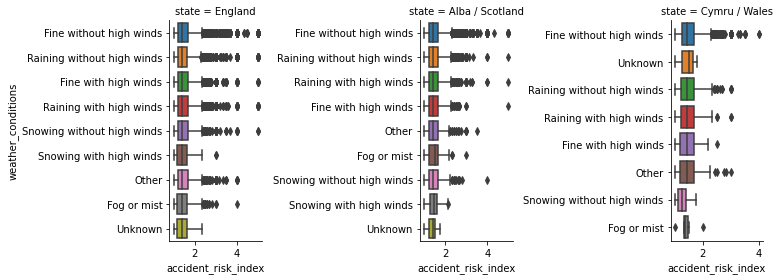

In [ ]:
sns.catplot(y='weather_conditions',x='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','weather_conditions'],'accident_risk_index')

state          weather_conditions     count      mean       std  \
2   Alba / Scotland                 Fog or mist      88.0  1.487159  0.359863   
4   Alba / Scotland     Raining with high winds    2382.0  1.483971  0.370622   
7   Alba / Scotland  Snowing without high winds     401.0  1.483691  0.363948   
6   Alba / Scotland     Snowing with high winds      16.0  1.480000  0.346487   
1   Alba / Scotland     Fine without high winds   48232.0  1.477944  0.347410   
5   Alba / Scotland  Raining without high winds    6439.0  1.475912  0.348477   
14    Cymru / Wales  Raining without high winds    1033.0  1.469361  0.334326   
0   Alba / Scotland        Fine with high winds    1488.0  1.469126  0.340612   
17          England        Fine with high winds   13111.0  1.467861  0.383411   
3   Alba / Scotland                       Other     606.0  1.467426  0.352646   
10    Cymru / Wales     Fine without high winds    9549.0  1.465039  0.335971   
18          England     Fine without high winds  321648.0  1.462327  0.362103   
13    Cymru / Wales     Raining with high winds     273.0  1.461282  0.340087   
21          England     Raining with high winds   17671.0  1.459675  0.372590   
9     Cymru / Wales        Fine with high winds     115.0  1.459043  0.328452   
12    Cymru / Wales                       Other     205.0  1.458976  0.372933   
24          England  Snowing without high winds    4182.0  1.458694  0.385165   
20          England                       Other    3720.0  1.455296  0.383898   
22          England  Raining without high winds   46236.0  1.454526  0.359402   
19          England                 Fog or mist     964.0  1.438838  0.370993   
16    Cymru / Wales                     Unknown      15.0  1.436000  0.266935   
11    Cymru / Wales                 Fog or mist       6.0  1.431667  0.327012   
23          England     Snowing with high winds     233.0  1.431416  0.347016   
25          England                     Unknown      88.0  1.420341  0.331092   
8   Alba / Scotland                     Unknown      15.0  1.395333  0.219117   
15    Cymru / Wales  Snowing without high winds      25.0  1.278000  0.233095   

    min     25%    50%     75%   max  
2   1.0  1.2450  1.500  1.6700  3.00  
4   1.0  1.2500  1.440  1.6700  5.00  
7   1.0  1.2500  1.430  1.6700  4.00  
6   1.0  1.2975  1.445  1.6250  2.14  
1   1.0  1.2500  1.440  1.6700  5.00  
5   1.0  1.2500  1.430  1.6700  5.00  
14  1.0  1.2300  1.430  1.6700  3.00  
0   1.0  1.2500  1.435  1.6700  5.00  
17  1.0  1.2000  1.410  1.6700  5.00  
3   1.0  1.2500  1.400  1.6475  3.50  
10  1.0  1.2500  1.430  1.6700  4.00  
18  1.0  1.2100  1.420  1.6700  5.00  
13  1.0  1.2200  1.420  1.6700  3.00  
21  1.0  1.2000  1.420  1.6700  5.00  
9   1.0  1.2000  1.430  1.6850  2.50  
12  1.0  1.2000  1.420  1.6700  3.00  
24  1.0  1.2000  1.400  1.6700  5.00  
20  1.0  1.2000  1.400  1.6700  4.00  
22  1.0  1.2000  1.400  1.6400  5.00  
19  1.0  1.1700  1.400  1.6550  4.00  
16  1.0  1.2500  1.500  1.6550  1.80  
11  1.0  1.3300  1.380  1.4825  2.00  
23  1.0  1.1700  1.400  1.6400  3.00  
25  1.0  1.1650  1.380  1.6550  2.33  
8   1.0  1.2350  1.400  1.5000  1.76  
15  1.0  1.1000  1.270  1.4000  1.75

#### The above plot explains that in all states the accident risk index is almost similar if any type of weather condition. Except for snowy and high wind weather conditions.

### Let's compare the state-wise total accident count by weather condition.

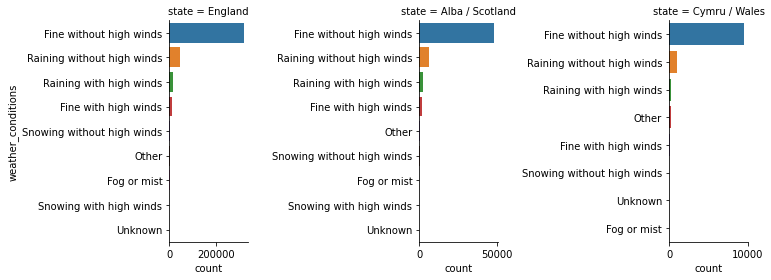

In [ ]:
sns.catplot(y='weather_conditions',x='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'weather_conditions':'str'}).groupby(['state','weather_conditions'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'weather_conditions':'str'}).groupby(['state','weather_conditions'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state          weather_conditions   count
18          England     Fine without high winds  321648
1   Alba / Scotland     Fine without high winds   48232
22          England  Raining without high winds   46236
21          England     Raining with high winds   17671
17          England        Fine with high winds   13111
10    Cymru / Wales     Fine without high winds    9549
5   Alba / Scotland  Raining without high winds    6439
24          England  Snowing without high winds    4182
20          England                       Other    3720
4   Alba / Scotland     Raining with high winds    2382
0   Alba / Scotland        Fine with high winds    1488
14    Cymru / Wales  Raining without high winds    1033
19          England                 Fog or mist     964
3   Alba / Scotland                       Other     606
7   Alba / Scotland  Snowing without high winds     401
13    Cymru / Wales     Raining with high winds     273
23          England     Snowing with high winds     233
12    Cymru / Wales                       Other     205
9     Cymru / Wales        Fine with high winds     115
2   Alba / Scotland                 Fog or mist      88
25          England                     Unknown      88
15    Cymru / Wales  Snowing without high winds      25
6   Alba / Scotland     Snowing with high winds      16
16    Cymru / Wales                     Unknown      15
8   Alba / Scotland                     Unknown      15
11    Cymru / Wales                 Fog or mist       6

#### In all the states of the united kingdom,   higher number of accidents in fine weather condition.

### Let's compare the state-wise total accident casualties by weather condition.

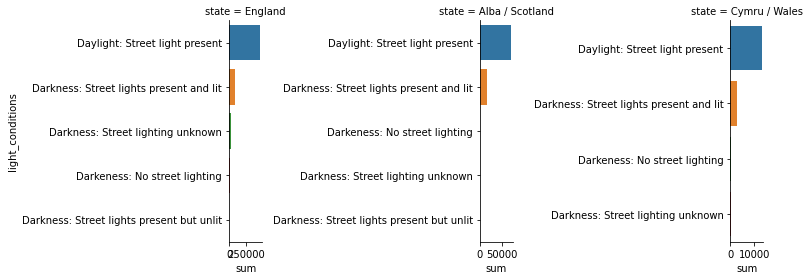

In [ ]:
sns.catplot(y='weather_conditions',x='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'light_conditions':'str'}).groupby(['state','light_conditions'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'weather_conditions':'str'}).groupby(['state','weather_conditions'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state          weather_conditions     sum
18          England     Fine without high winds  471306
1   Alba / Scotland     Fine without high winds   71586
22          England  Raining without high winds   66577
21          England     Raining with high winds   25778
17          England        Fine with high winds   19289
10    Cymru / Wales     Fine without high winds   13711
5   Alba / Scotland  Raining without high winds    9458
24          England  Snowing without high winds    6072
20          England                       Other    5283
4   Alba / Scotland     Raining with high winds    3609
0   Alba / Scotland        Fine with high winds    2203
14    Cymru / Wales  Raining without high winds    1478
19          England                 Fog or mist    1345
3   Alba / Scotland                       Other     874
7   Alba / Scotland  Snowing without high winds     610
13    Cymru / Wales     Raining with high winds     383
23          England     Snowing with high winds     331
12    Cymru / Wales                       Other     265
9     Cymru / Wales        Fine with high winds     157
2   Alba / Scotland                 Fog or mist     116
25          England                     Unknown     116
15    Cymru / Wales  Snowing without high winds      29
6   Alba / Scotland     Snowing with high winds      25
16    Cymru / Wales                     Unknown      22
8   Alba / Scotland                     Unknown      18
11    Cymru / Wales                 Fog or mist      10

#### In all the states of the united kingdom,   higher number of accident casualties in fine weather condition.

#### Let's see how accident risk index changes on rural and urban areas.

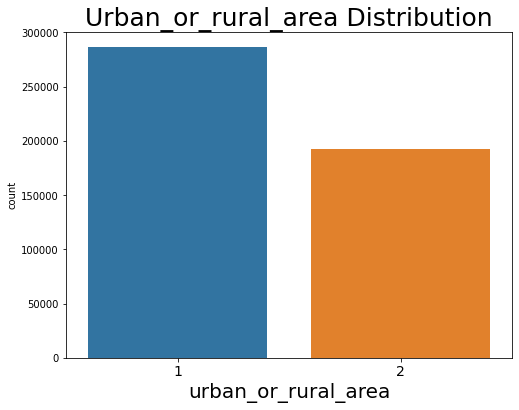

In [ ]:
count_plot(train,'urban_or_rural_area')

In [ ]:
train['urban_or_rural_area'].value_counts()

1    286263
2    192478
Name: urban_or_rural_area, dtype: int64

#### Most number of accidents in urban area.

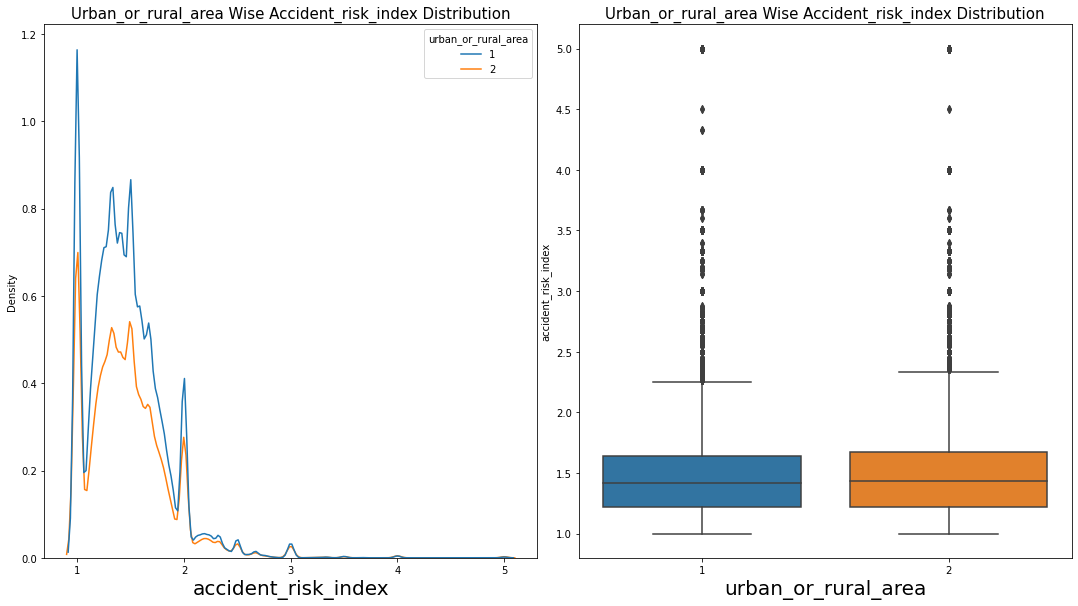

In [ ]:
side_by_side_plot(train,'urban_or_rural_area','accident_risk_index')

In [ ]:
group_summary(train,'urban_or_rural_area','accident_risk_index')

urban_or_rural_area     count      mean       std  min   25%   50%   75%  \
1                    2  192478.0  1.473544  0.377624  1.0  1.22  1.43  1.67   
0                    1  286263.0  1.456644  0.349248  1.0  1.22  1.42  1.64   

   max  
1  5.0  
0  5.0

#### There is no significant correlation between the average accident risk index and the area type.

### Let's compare the state-wise accident risk index with area types.

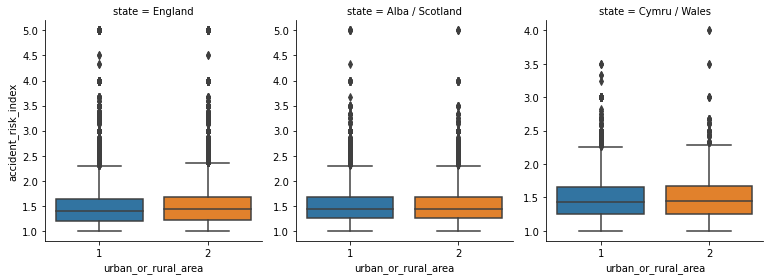

In [ ]:
sns.catplot(x='urban_or_rural_area',y='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','urban_or_rural_area'],'accident_risk_index')

state  urban_or_rural_area     count      mean       std  min  \
3    Cymru / Wales                    2    1697.0  1.492964  0.367123  1.0   
1  Alba / Scotland                    2   17088.0  1.487392  0.362440  1.0   
0  Alba / Scotland                    1   42579.0  1.473769  0.342616  1.0   
5          England                    2  173693.0  1.471992  0.379155  1.0   
2    Cymru / Wales                    1    9524.0  1.459664  0.330279  1.0   
4          England                    1  234160.0  1.453408  0.351097  1.0   

    25%   50%   75%  max  
3  1.25  1.44  1.67  4.0  
1  1.25  1.44  1.67  5.0  
0  1.25  1.44  1.67  5.0  
5  1.21  1.43  1.67  5.0  
2  1.25  1.43  1.65  3.5  
4  1.20  1.40  1.64  5.0

#### The above plot explains that in all states the accident risk index is almost similar even if the area is urban or rural.

### Let's compare the state-wise total accident count by area type.

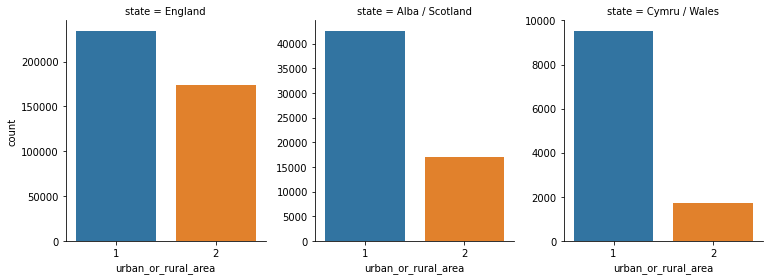

In [ ]:
sns.catplot(x='urban_or_rural_area',y='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'urban_or_rural_area':'str'}).groupby(['state','urban_or_rural_area'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'urban_or_rural_area':'str'}).groupby(['state','urban_or_rural_area'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state urban_or_rural_area   count
4          England                   1  234160
5          England                   2  173693
0  Alba / Scotland                   1   42579
1  Alba / Scotland                   2   17088
2    Cymru / Wales                   1    9524
3    Cymru / Wales                   2    1697

#### In all the states of the united kingdom,   higher number of accidents in urban area.

### Let's compare the state-wise total accident casualties by area types.

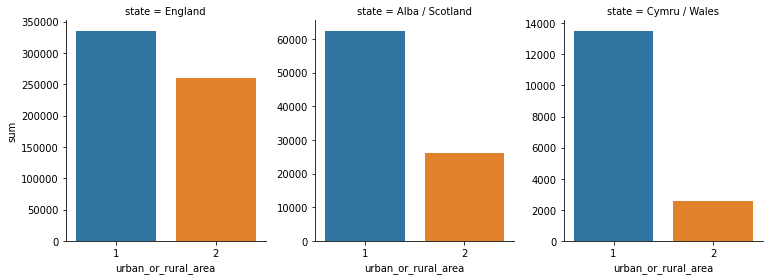

In [ ]:
sns.catplot(x='urban_or_rural_area',y='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'urban_or_rural_area':'str'}).groupby(['state','urban_or_rural_area'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'urban_or_rural_area':'str'}).groupby(['state','urban_or_rural_area'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state urban_or_rural_area     sum
4          England                   1  335286
5          England                   2  260811
0  Alba / Scotland                   1   62407
1  Alba / Scotland                   2   26092
2    Cymru / Wales                   1   13513
3    Cymru / Wales                   2    2542

#### In all the states of the united kingdom,   higher number of accident casualties in urban area.

#### Let's see whether the police officers have attended the accident spot or not.

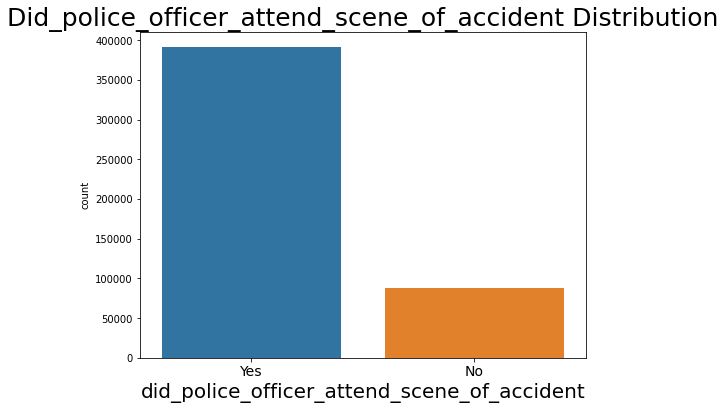

In [ ]:
count_plot(train,'did_police_officer_attend_scene_of_accident')

In [ ]:
train['did_police_officer_attend_scene_of_accident'].value_counts()

Yes    391064
No      87677
Name: did_police_officer_attend_scene_of_accident, dtype: int64

#### Most road accidents scenes are attended by the police. 

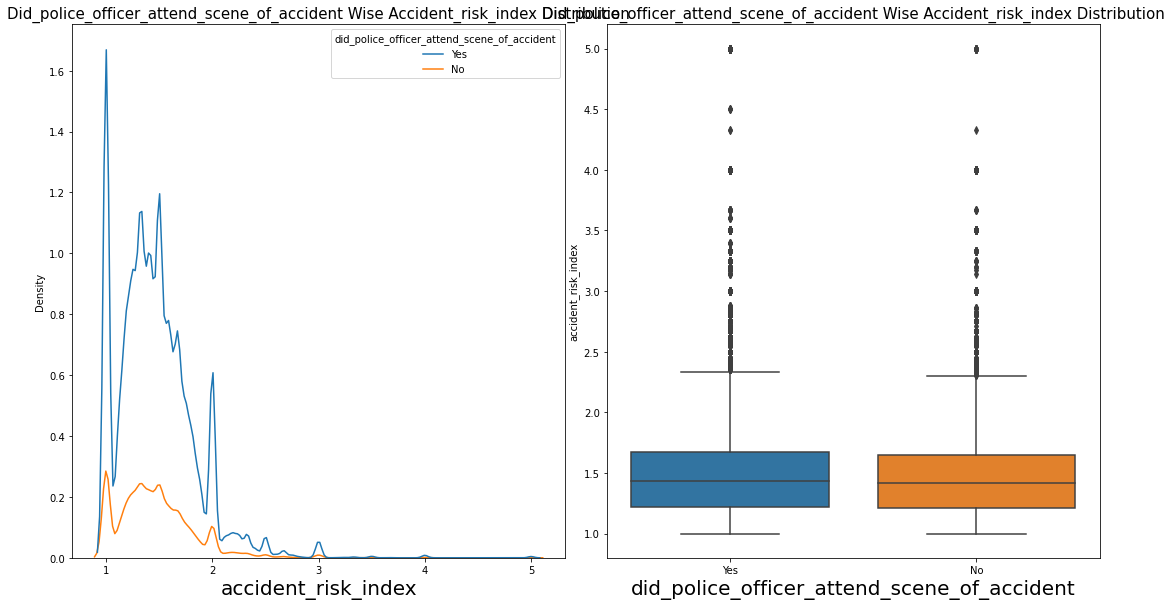

In [ ]:
side_by_side_plot(train,'did_police_officer_attend_scene_of_accident','accident_risk_index')

In [ ]:
group_summary(train,'did_police_officer_attend_scene_of_accident','accident_risk_index')

did_police_officer_attend_scene_of_accident     count      mean       std  \
1                                         Yes  391064.0  1.464678  0.362257   
0                                          No   87677.0  1.457911  0.355395   

   min   25%   50%   75%  max  
1  1.0  1.22  1.43  1.67  5.0  
0  1.0  1.21  1.42  1.65  5.0

#### The accident risk index same.

### Let's compare the state-wise accident risk index with whether the police officers have attended the accident spot or not.

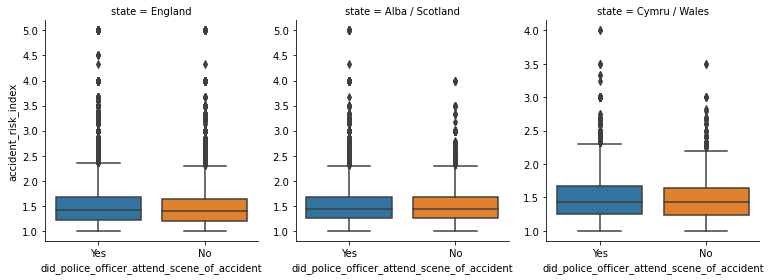

In [ ]:
sns.catplot(x='did_police_officer_attend_scene_of_accident',y='accident_risk_index',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=train,
                 height=4, aspect=.9, 
                kind="box");

In [ ]:
group_summary(train,['state','did_police_officer_attend_scene_of_accident'],'accident_risk_index')

state did_police_officer_attend_scene_of_accident     count  \
1  Alba / Scotland                                         Yes   50587.0   
0  Alba / Scotland                                          No    9080.0   
3    Cymru / Wales                                         Yes    9212.0   
5          England                                         Yes  331265.0   
2    Cymru / Wales                                          No    2009.0   
4          England                                          No   76588.0   

       mean       std  min   25%   50%   75%  max  
1  1.478180  0.349819  1.0  1.25  1.44  1.67  5.0  
0  1.474836  0.340797  1.0  1.25  1.44  1.67  4.0  
3  1.465827  0.336083  1.0  1.25  1.43  1.67  4.0  
5  1.462584  0.364773  1.0  1.21  1.42  1.67  5.0  
2  1.459532  0.337353  1.0  1.24  1.43  1.64  3.5  
4  1.455862  0.357495  1.0  1.20  1.40  1.64  5.0

#### The above plot explains that in all states the accident risk index is almost same.

### Let's compare the state-wise total accident count with whether the police officers have attended the accident spot or not.

In [ ]:
sns.catplot(x='did_police_officer_attend_scene_of_accident',y='count',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'did_police_officer_attend_scene_of_accident':'str'}).groupby(['state','did_police_officer_attend_scene_of_accident'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'did_police_officer_attend_scene_of_accident':'str'}).groupby(['state','did_police_officer_attend_scene_of_accident'])
            ['accident_id'].agg({'count'}).reset_index().sort_values('count',ascending=False))

state did_police_officer_attend_scene_of_accident   count
5          England                                         Yes  331265
4          England                                          No   76588
1  Alba / Scotland                                         Yes   50587
3    Cymru / Wales                                         Yes    9212
0  Alba / Scotland                                          No    9080
2    Cymru / Wales                                          No    2009

#### In all the states of the united kingdom,   higher number of accidents scenes are attended by the police. 

### Let's compare the state-wise total accident casualties with whether the police officers have attended the accident spot or not.

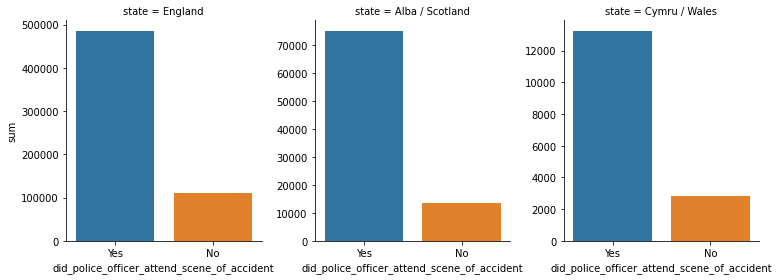

In [ ]:
sns.catplot(x='did_police_officer_attend_scene_of_accident',y='sum',
                 col='state',col_wrap=3,sharey=False,sharex=False,
            data=(train.astype({'did_police_officer_attend_scene_of_accident':'str'}).groupby(['state','did_police_officer_attend_scene_of_accident'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False)),
                 height=4, aspect=.9,kind="bar");               

In [ ]:
(train.astype({'did_police_officer_attend_scene_of_accident':'str'}).groupby(['state','did_police_officer_attend_scene_of_accident'])
            ['number_of_casualties'].agg({'sum'}).reset_index().sort_values('sum',ascending=False))

state did_police_officer_attend_scene_of_accident     sum
5          England                                         Yes  485465
4          England                                          No  110632
1  Alba / Scotland                                         Yes   75103
0  Alba / Scotland                                          No   13396
3    Cymru / Wales                                         Yes   13247
2    Cymru / Wales                                          No    2808

#### In all the states of the united kingdom, the higher number of accident casualty scenes are attended by the police. 

### By the police forces group-wise.Let's see how many police officers attend the accident scene and how many do not.

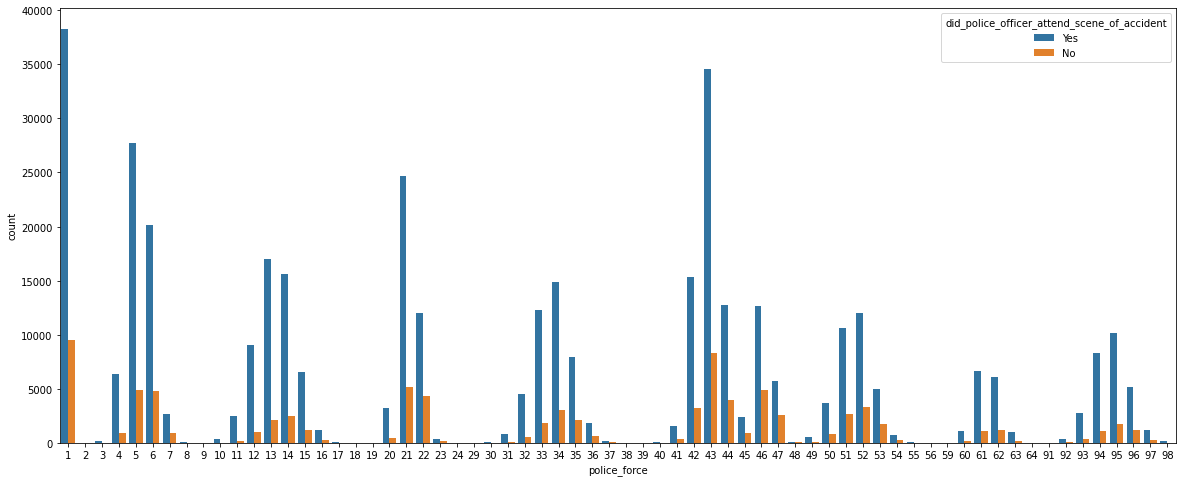

In [ ]:
plt.figure(figsize=(20,8));
sns.countplot(x=train['police_force'],hue=train['did_police_officer_attend_scene_of_accident']);

### Let's do some feature engineering on date and time column.

In [ ]:
def pre_process(df):

  df['date_time']=pd.to_datetime(df["date"].astype('str'))
  #df[['Year', 'Month', 'Day', 'Hour', 'Minute']]=df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype('str')
  #df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']],infer_datetime_format=True,errors='coerce').dt.tz_localize(None)
  df['day']=df['date_time'].dt.day
  df['day_label']=df['date_time'].dt.day_name()
  df['day_number']=df['date_time'].dt.dayofweek
  df['month_number']=df['date_time'].dt.month
  df['month_label']=df['date_time'].dt.strftime('%b')
  df['year_quarter']=df['date_time'].dt.quarter
  df['week_of_year']=df['date_time'].dt.week
  df['year']= df['date_time'].dt.year
  df['dayofmonth'] = df['date_time'].dt.daysinmonth
  df['dayofyear'] = df['date_time'].dt.day_of_year
  df['hour']=pd.to_datetime(df["time"],errors='coerce').dt.hour



  def month2seasons(x):
    season=""
    if x in [12, 1, 2]:
        season = 'winter'
    elif x in [3, 4, 5]:
        season = 'spring'
    elif x in [6, 7, 8]:
        season = 'summer'
    elif x in [9,10, 11]:
        season = 'autumn'
    return season

 
  df['seasons']=df['month_number'].apply(month2seasons)


  def hours2timing(x):
    if x in range(20,23):
        timing = 'Night'
    elif x in range(5,12):
        timing = 'Morning'
    elif x in range(12, 16):
        timing = 'Afternoon'
    elif x in range(16, 20):
        timing = 'Evening'
    elif x in [23,0,1,2,3,4]:
        timing = 'Midnight'    
    else:
        timing = 'X'
    return timing



  df['timings']=df['hour'].apply(hours2timing) 



  return df

In [ ]:
train=pre_process(train)

### Let's see over the one year how the count of police officers who attend the scene of the accident and those who do not.

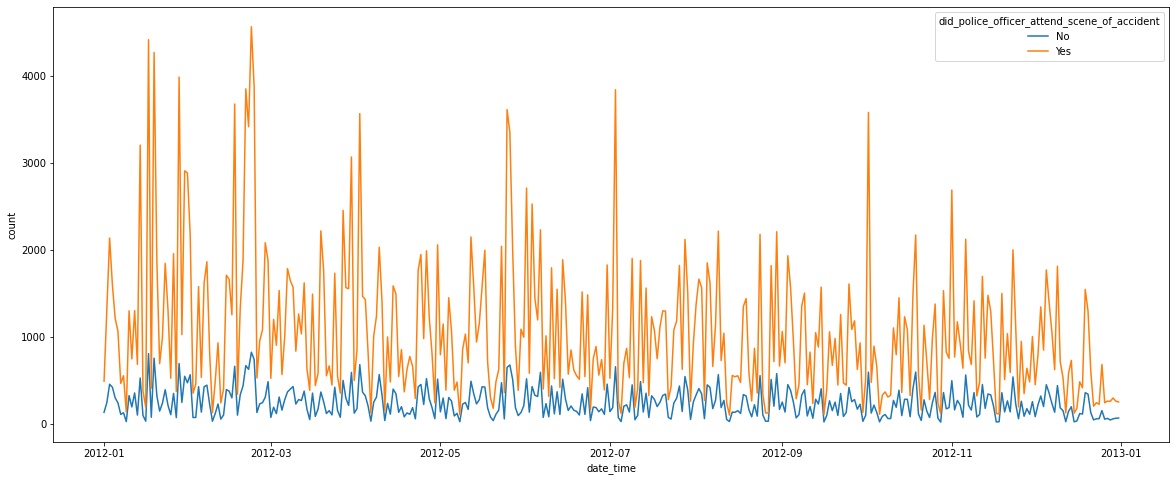

In [ ]:
plt.figure(figsize=(20,8));
sns.lineplot(data=train.groupby(['date_time','did_police_officer_attend_scene_of_accident'])['did_police_officer_attend_scene_of_accident'].agg({'count'}).reset_index(),
             x='date_time',y='count',hue='did_police_officer_attend_scene_of_accident')


### Month-wise,

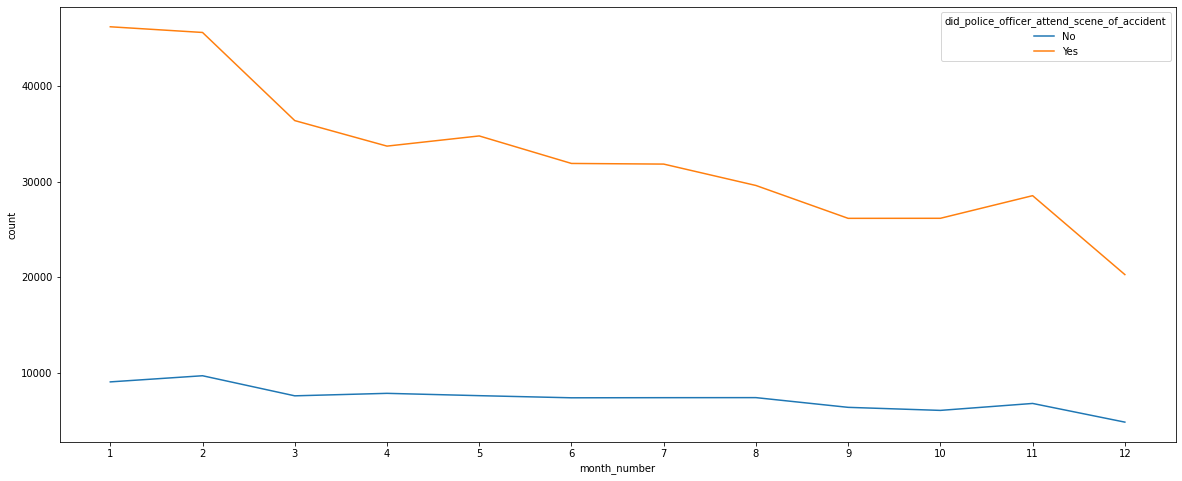

In [ ]:
plt.figure(figsize=(20,8));
sns.lineplot(data=train.groupby(['month_number','did_police_officer_attend_scene_of_accident'])['did_police_officer_attend_scene_of_accident'].agg({'count'}).reset_index(),
             x='month_number',y='count',hue='did_police_officer_attend_scene_of_accident')
plt.xticks(range(1,13));


#### Over the 12 months, the count of police officers who attend the accident scene is increased in the month of February, May, July, and November.

#### Over the 12 months, the count of police officers who do not attend the accident scene is increased in the month of February, November. 

### Week-wise,

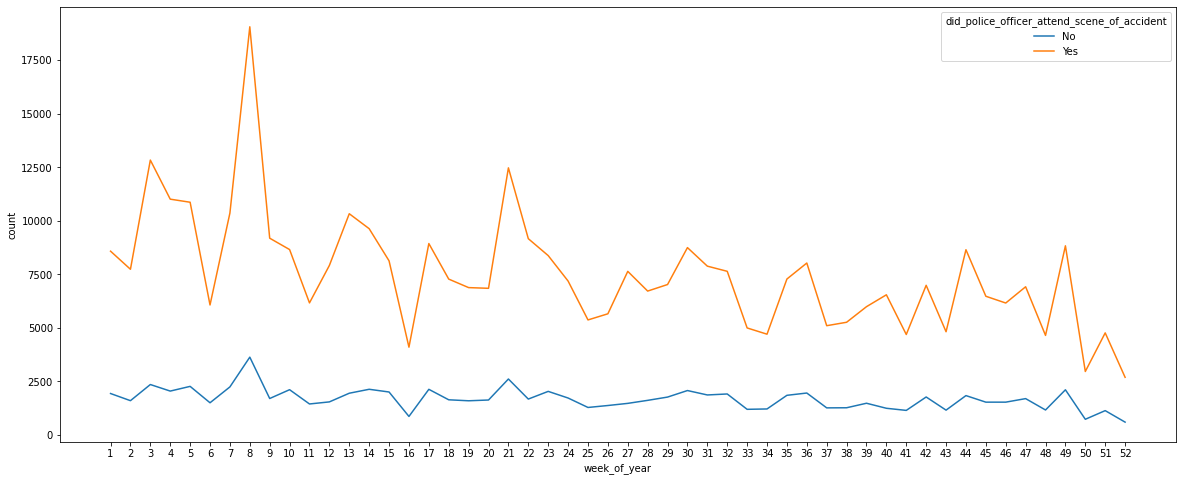

In [ ]:
plt.figure(figsize=(20,8));
sns.lineplot(data=train.groupby(['week_of_year','did_police_officer_attend_scene_of_accident'])['did_police_officer_attend_scene_of_accident'].agg({'count'}).reset_index(),
             x='week_of_year',y='count',hue='did_police_officer_attend_scene_of_accident')
plt.xticks(range(1,53));


### Hour-wise

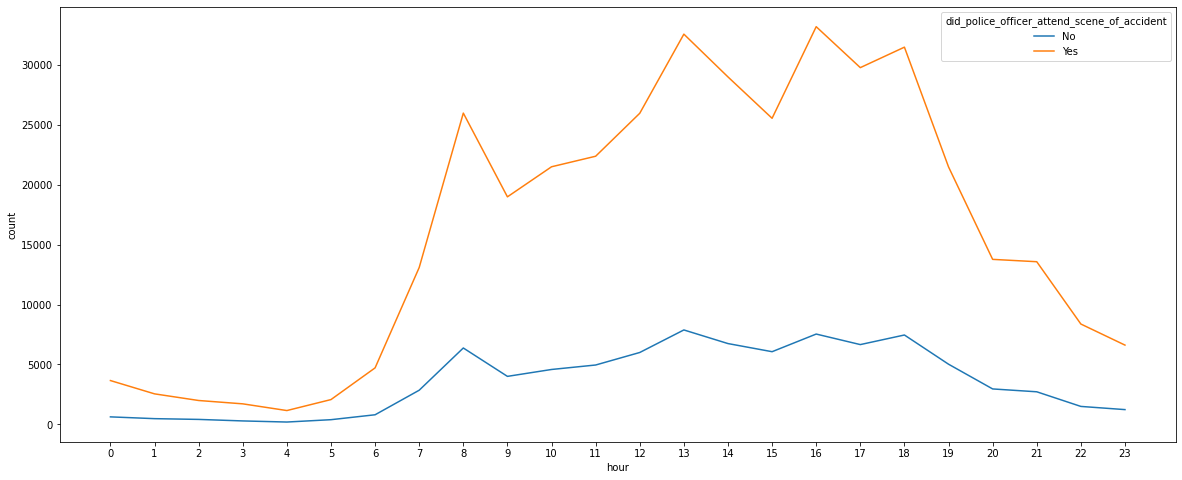

In [ ]:
plt.figure(figsize=(20,8));
sns.lineplot(data=train.groupby(['hour','did_police_officer_attend_scene_of_accident'])['did_police_officer_attend_scene_of_accident'].agg({'count'}).reset_index(),
             x='hour',y='count',hue='did_police_officer_attend_scene_of_accident')
plt.xticks(range(0,24));

### Day of Week wise,

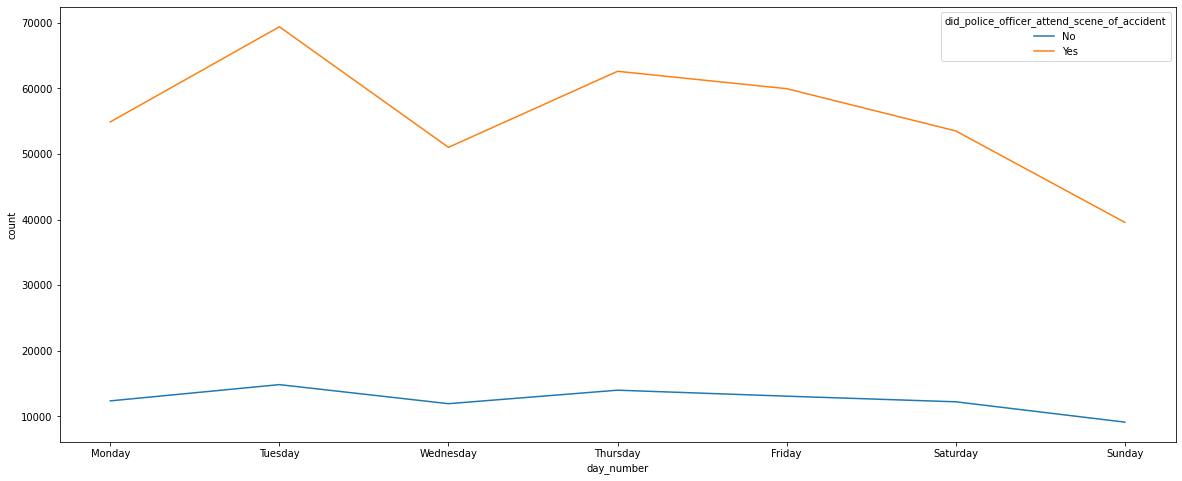

In [ ]:
plt.figure(figsize=(20,8));
sns.lineplot(data=train.groupby(['day_number','did_police_officer_attend_scene_of_accident'])['did_police_officer_attend_scene_of_accident'].agg({'count'}).reset_index(),
             x='day_number',y='count',hue='did_police_officer_attend_scene_of_accident')
plt.xticks(range(0,7),['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']);  

### Let's see how the accident risk index changes over one year.

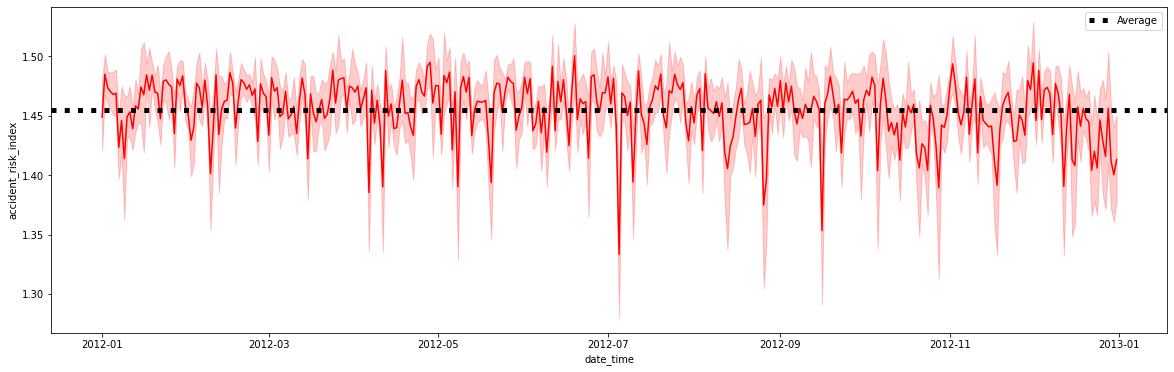

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['date_time'],y=train['accident_risk_index'],color="Red")
yr.axhline(train.groupby('date_time')['accident_risk_index'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend();          

#### The above plot explains that over the one year the accident risk index is has had a lot of ups and downs.

#### In some months the accident risk index is very lower than the yearly average accident risk index.

### Let's see how the accident count changes over one year.

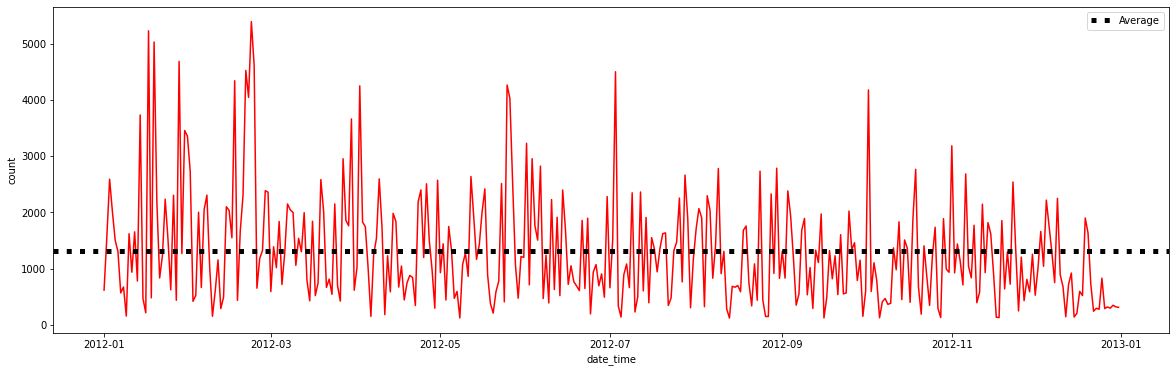

In [ ]:
plt.figure(figsize=(20,6))
accident_total=sns.lineplot(data=train.groupby('date_time')['accident_id'].agg({'count'}).reset_index(),
               x='date_time',y='count',color="Red")
accident_total.axhline(train.groupby('date_time')['accident_id'].agg({'count'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend(); 

#### The above plot explains that over the one year the accident count is has had a lot of ups and downs.

#### In some months the accident count is very lower than the yearly average accident count.

### Let's see how the accident casualties changes over one year.

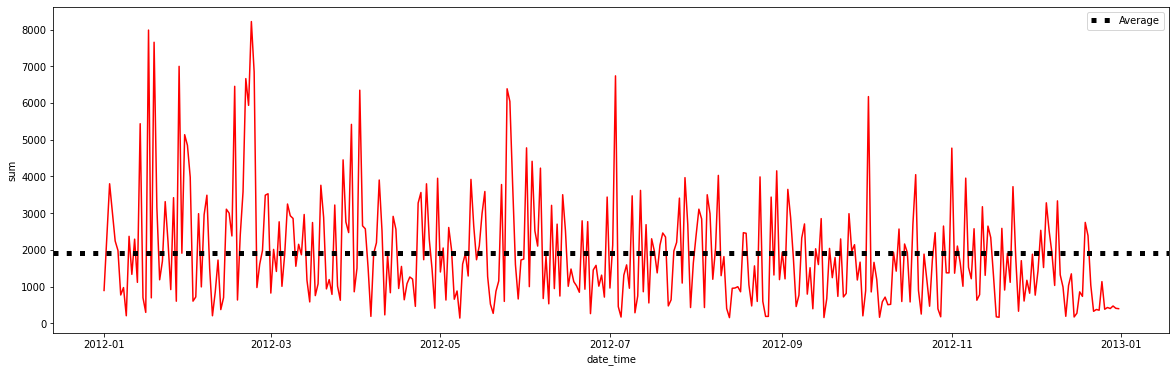

In [ ]:
plt.figure(figsize=(20,6))
p=sns.lineplot(data=train.groupby('date_time')['number_of_casualties'].agg({'sum'}).reset_index(),
               x='date_time',y='sum',color="Red")
p.axhline(train.groupby('date_time')['number_of_casualties'].agg({'sum'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend(); 

#### The above plot explains that over the one year the accident casualties count is has had a lot of ups and downs.

#### In some months the accident casualties count is very lower than the yearly average accident casualties count.

### Let's see how the accident risk index changes over 12 months.

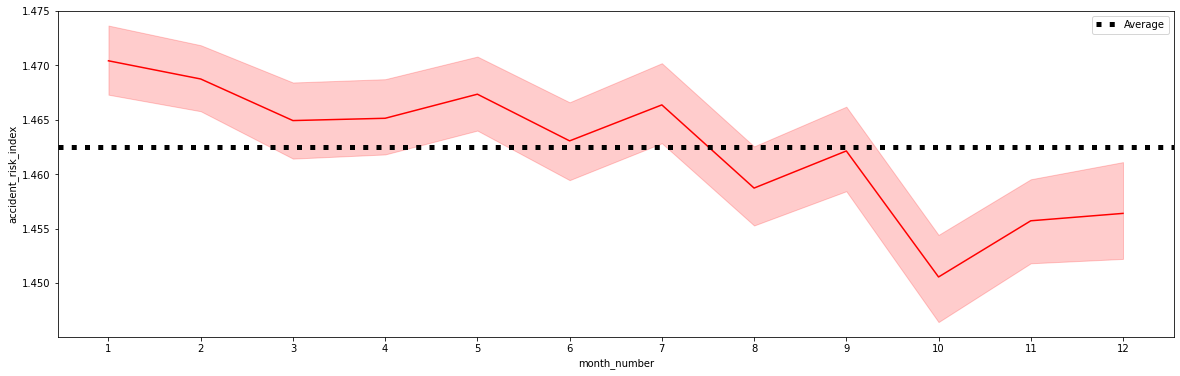

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['month_number'],y=train['accident_risk_index'],color="Red")
yr.axhline(train.groupby('month_number')['accident_risk_index'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,13));         
plt.legend();          

#### The above plot explains that over the 12 months the accident risk index is has had a lot of ups and downs.

#### The month of August and after august, the accident risk index is very lower than the monthly average accident risk index.

### Let's see how the accident count changes over 12 months.

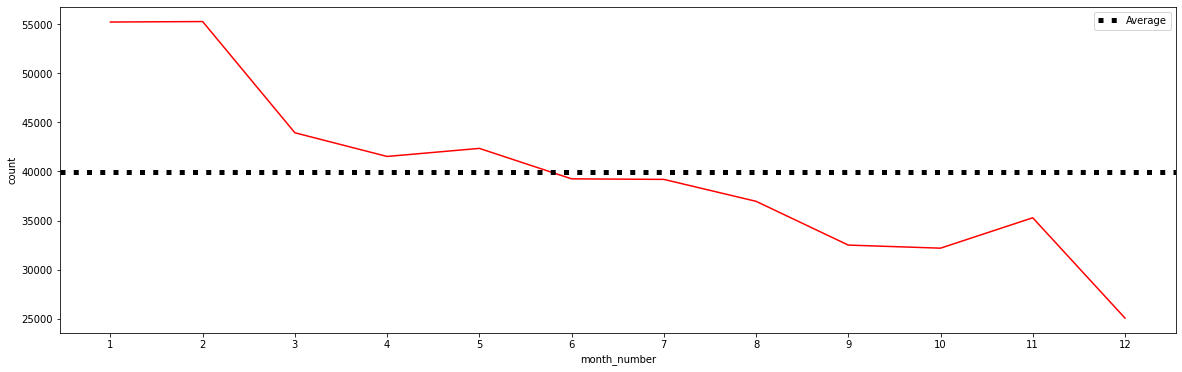

In [ ]:
plt.figure(figsize=(20,6))
accident_total=sns.lineplot(data=train.groupby('month_number')['accident_id'].agg({'count'}).reset_index(),
               x='month_number',y='count',color="Red")
accident_total.axhline(train.groupby('month_number')['accident_id'].agg({'count'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,13));          
plt.legend(); 

#### The above plot explains that over the 12 months the accident count is has had a lot of ups and downs.

#### The month of June and after june, the accident count is very lower than the monthly average accident count.

### Let's see how the accident casualties changes over 12 months.

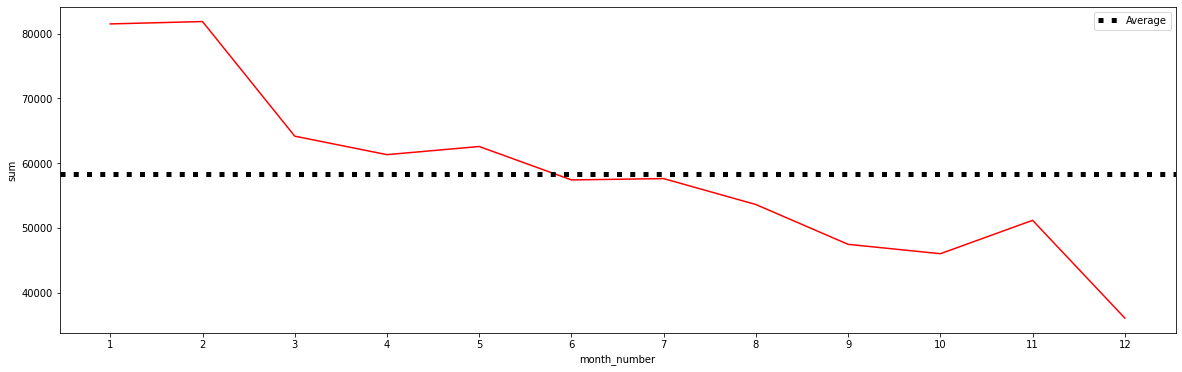

In [ ]:
plt.figure(figsize=(20,6))
p=sns.lineplot(data=train.groupby('month_number')['number_of_casualties'].agg({'sum'}).reset_index(),
               x='month_number',y='sum',color="Red")
p.axhline(train.groupby('month_number')['number_of_casualties'].agg({'sum'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,13));          
plt.legend(); 

#### The above plot explains that over the 12 months the accident casualties is has had a lot of ups and downs.

#### The month of June and after june, the accident casualties is very lower than the monthly average accident casualties.

### Let's see how the accident risk index changes over 52 weeks of the year.

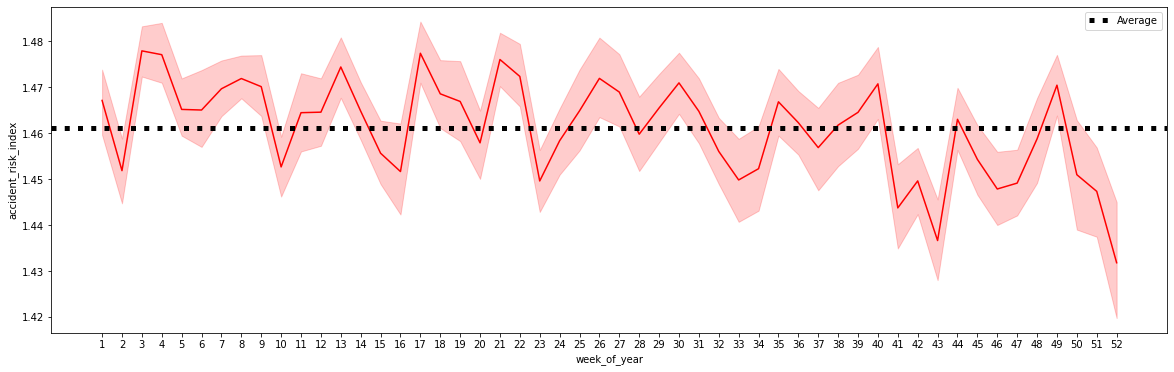

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['week_of_year'],y=train['accident_risk_index'],color="Red")
yr.axhline(train.groupby('week_of_year')['accident_risk_index'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,53));         
plt.legend();          

#### The above plot explains that over the 52 weeks of the year accident risk index is has had a lot of ups and downs.

### Let's see how the accident count changes over 52 weeks of the year.

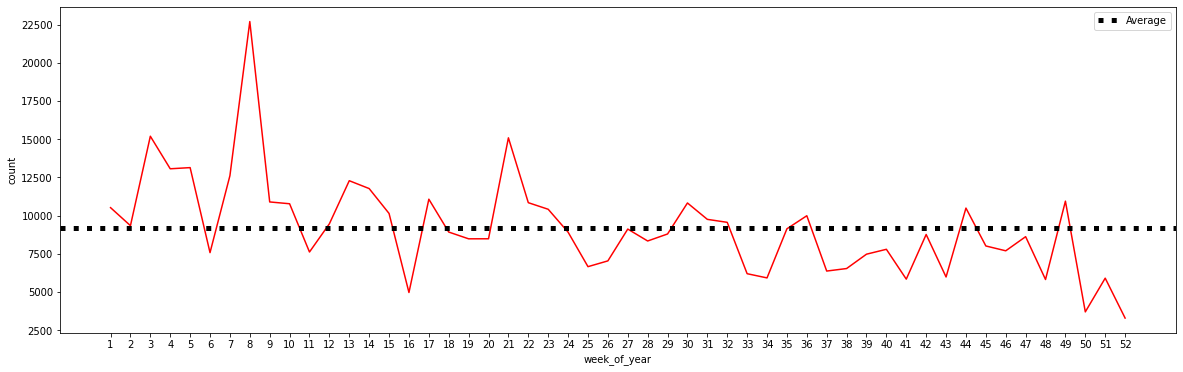

In [ ]:
plt.figure(figsize=(20,6))
accident_total=sns.lineplot(data=train.groupby('week_of_year')['accident_id'].agg({'count'}).reset_index(),
               x='week_of_year',y='count',color="Red")
accident_total.axhline(train.groupby('week_of_year')['accident_id'].agg({'count'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,53));          
plt.legend(); 

#### The above plot explains that over the 53 weeks of the year the accident count is has had a lot of ups and downs.

### Let's see how the accident casualties changes over 52 weeks of the year.

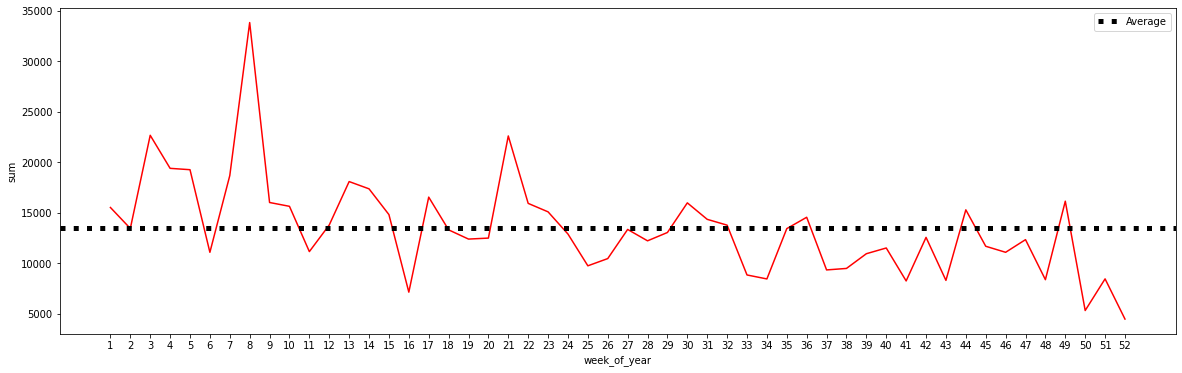

In [ ]:
plt.figure(figsize=(20,6))
p=sns.lineplot(data=train.groupby('week_of_year')['number_of_casualties'].agg({'sum'}).reset_index(),
               x='week_of_year',y='sum',color="Red")
p.axhline(train.groupby('week_of_year')['number_of_casualties'].agg({'sum'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,53));          
plt.legend(); 

#### The above plot explains that over the 52 weeks of the year the accident casualties is has had a lot of ups and downs.

### Let's see how the accident risk index changes over 24 hours of the day.

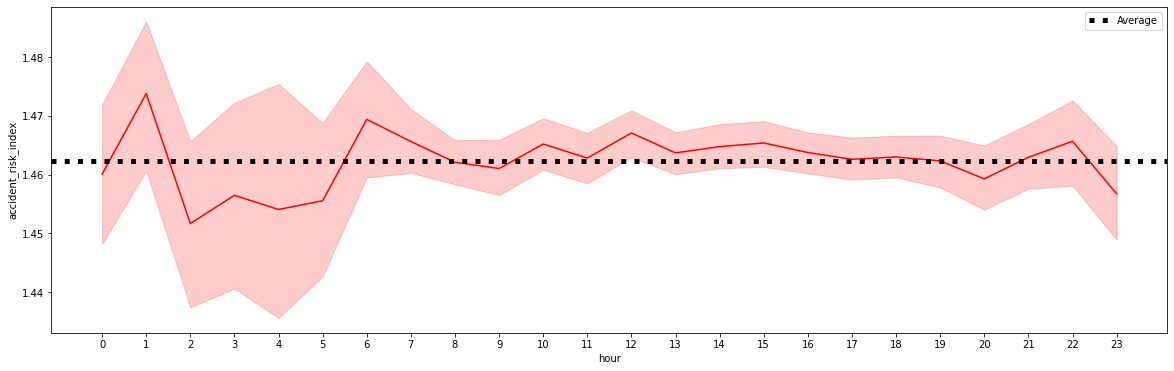

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['hour'],y=train['accident_risk_index'],color="Red")
yr.axhline(train.groupby('hour')['accident_risk_index'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(0,24));         
plt.legend();          

#### The above plot explains that over 24 hours accident risk index is has had a lot of ups and downs.

#### From the time midnight 2'o clock to 5'o clock the accident risk index is lower than the per day accident risk index's  average

### Let's see how the accident count changes over 24 hours of the day.

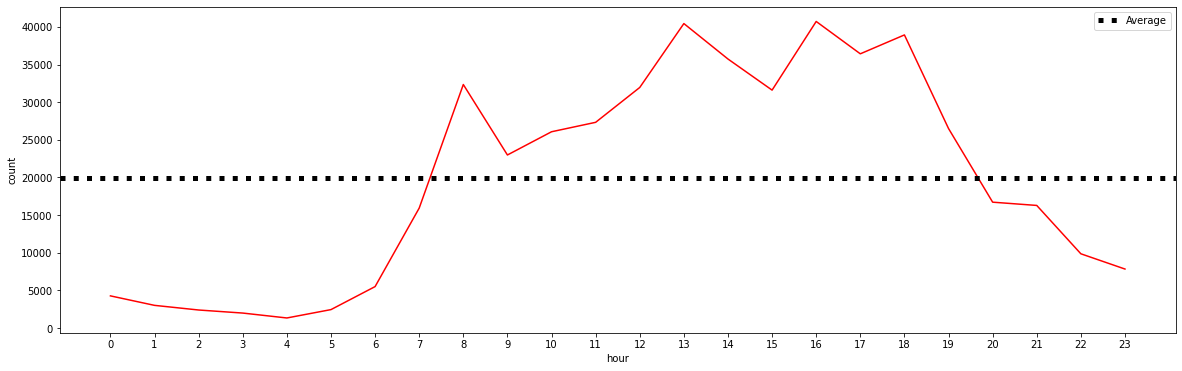

In [ ]:
plt.figure(figsize=(20,6))
accident_total=sns.lineplot(data=train.groupby('hour')['accident_id'].agg({'count'}).reset_index(),
               x='hour',y='count',color="Red")
accident_total.axhline(train.groupby('hour')['accident_id'].agg({'count'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(0,24));          
plt.legend(); 

#### The above plot explains that the 24 hours accident count is has had a lot of ups and downs.

#### From the time midnight 12'o clock to 5'o clock the accident count is lower than the per day accident counts average.

#### From the time morning 7'o clock to evening 7'o clock the accident count is higher than the per day accident counts average.

### Let's see how the accident casualties changes over 24 hours of the day.

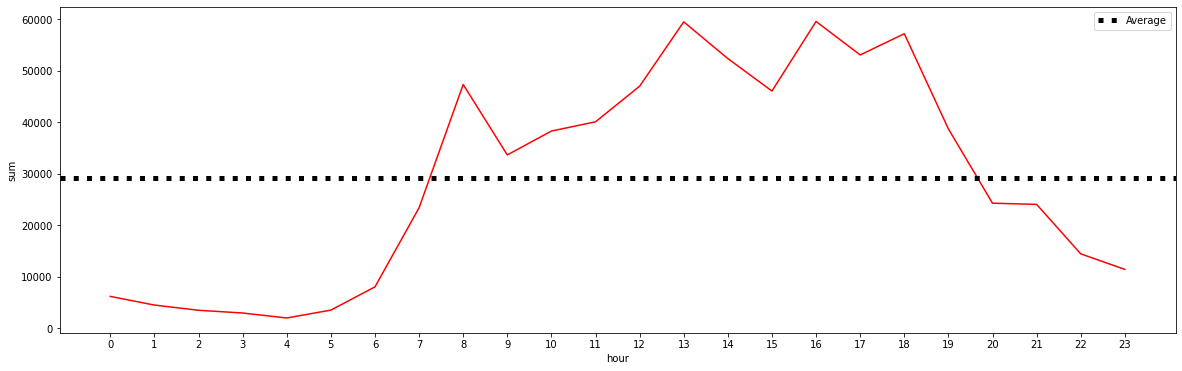

In [ ]:
plt.figure(figsize=(20,6))
p=sns.lineplot(data=train.groupby('hour')['number_of_casualties'].agg({'sum'}).reset_index(),
               x='hour',y='sum',color="Red")
p.axhline(train.groupby('hour')['number_of_casualties'].agg({'sum'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(0,24));          
plt.legend(); 

#### The above plot explains that the 24 hours accident casualties is has had a lot of ups and downs.

#### From the time midnight 12'o clock to 5'o clock the accident casualties is lower than the per day accident casualties average.


#### From the time morning 7'o clock to evening 7'o clock the accident casualties is higher than the per day accident casualties average.

### Let's see how the accident risk index changes over 7 days of the week. 

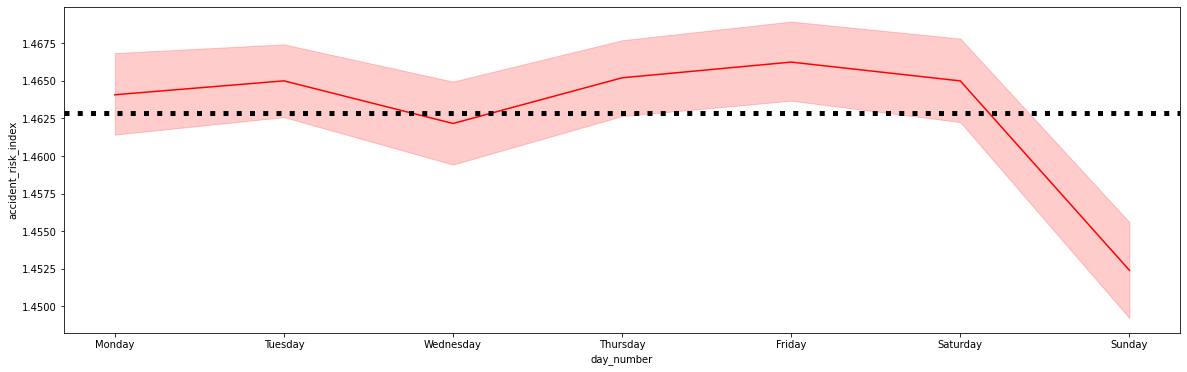

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['day_number'],y=train['accident_risk_index'],color="Red")
yr.axhline(train.groupby('day_number')['accident_risk_index'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(0,7));         
plt.xticks(range(0,7),['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']);        

#### The above plot explains that over 7 days of the week the accident risk index is has had a lot of ups and downs.

#### On Wednesday and weekends the accident risk index is lower than the per week accident risk index's  average

### Let's see how the accident count changes over 7 days of the week. 

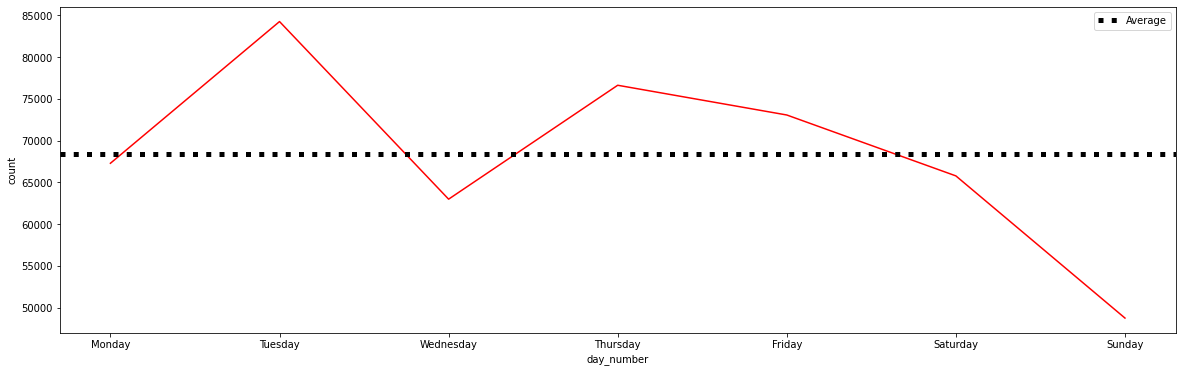

In [ ]:
plt.figure(figsize=(20,6))
accident_total=sns.lineplot(data=train.groupby('day_number')['accident_id'].agg({'count'}).reset_index(),
               x='day_number',y='count',color="Red")
accident_total.axhline(train.groupby('day_number')['accident_id'].agg({'count'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(0,7),['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']);          
plt.legend(); 

#### The above plot explains that over 7 days of the week the accident count is has had a lot of ups and downs.

#### On Wednesday and weekends the accident count is lower than the per week accident counts average.

### Let's see how the accident casualties changes over 7 days of the week. 

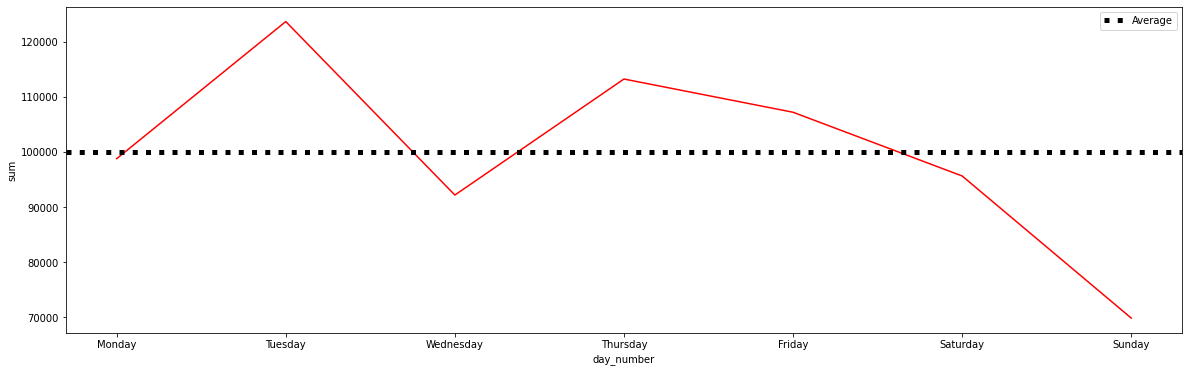

In [ ]:
plt.figure(figsize=(20,6))
p=sns.lineplot(data=train.groupby('day_number')['number_of_casualties'].agg({'sum'}).reset_index(),
               x='day_number',y='sum',color="Red")
p.axhline(train.groupby('day_number')['number_of_casualties'].agg({'sum'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(0,7),['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']);           
plt.legend(); 

#### The above plot explains that over 7 days of the week the accident casualties is has had a lot of ups and downs.

#### On Wednesday and weekends the accident casualties is lower than the per week accident casualties average